# Semi-conductor dataset
The semi-conductor dataset is a large dataset composed of nearly 600 features for testing semi-conductors. For detailed information consult the README.md

#### Objective and tasks
Our objective is to use the features to predict whether a semi-conductor has passed a validation test. In order to do so we need:
1. To reduces the number of features in the dataset either by dimension reduction techniques or by feature selection or by both. 
2. Predict whether a conductor passed or failed the test
3. Validate our predictions.    

#### Plan
"I have a plan, its a crazy plan, but a plan nonetheless" Angus from the Spy-dog animation

Our predictions will be effected essentially by two main decisions: 1. How to reduce the dataset and select the features and 2. What model to use. So our plan might be drawn like this:
1. Clean the data
2. Apply several dimension reduction or feature selection techniques: 
    - PCA and used the components as features
    - Singular Value Decomposition
    - Select the best features via correlations metrics
    - Select features via LASSO Regularization
    - Select features via Random Forest Gini Importance
    
3. Use the end features or components to predict via several models:
    - Logistic regression
    - Random forest
    - Gradient boosting machine
    - AdaBoosting
4. From step 3 we will have 20 combinations of reduction techniques and models, we may chose the top 3 or 4 of them and fine tune the model via hyperparameter tunning.
5. Validate the model

Note that there are many dimension reduction techniques and model types out there so my choices here are to some extent arbitrary derived only from my previous experience and current knowledge. So by all means any suggestions to improve this are welcomed.   


### Import libraries and data

In [232]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, matthews_corrcoef, RocCurveDisplay 
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
import pickle
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [233]:
df = pd.read_csv("uci-secom.csv")

In [234]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### Data cleaning

Let us first relabel the target column so that the test fail = 1 and the pass = 0 

In [235]:
df['Pass/Fail'] = df['Pass/Fail'].replace(to_replace=[-1,1], value=[0,1])

We may also `drop` the `Time` column as it won't be useful as a feature

In [236]:
df = df.drop('Time', axis=1)

Let us look at its distribution of the target.  

Text(0.5, 0, '1: Fail, 0: Pass')

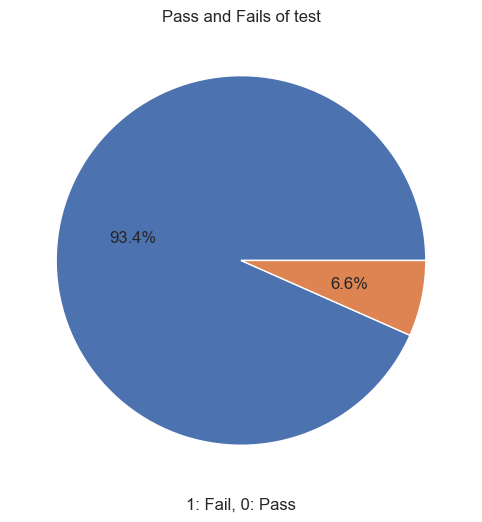

In [237]:
plt.figure(figsize=(10,6))
plt.pie(df['Pass/Fail'].value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

Our dataset is imbalanced so we need to bear this in mind when modeling

##### NaN handling
We were warned in the documentation that there are a lot of NaNs in this dataset, let us have a look 

In [238]:
np.count_nonzero(df.isna().sum())

538

Nearly all the columns have some missing values. 

In [239]:
df.isna().sum().sort_values(ascending=False).head(20)

157    1429
292    1429
293    1429
158    1429
492    1341
358    1341
85     1341
220    1341
246    1018
109    1018
110    1018
111    1018
518    1018
516    1018
245    1018
244    1018
382    1018
383    1018
384    1018
517    1018
dtype: int64

We see that there are columns with more NaNs than values, which won't help us in the prediction task, so let us remove all columns where there are more then 40% missing values 

In [240]:
def percentna(dataframe, threshold):
    '''Get a list of column names where the number of NaNs is above a % threshold'''
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold]
    return columns.tolist()

In [241]:
na_columns = percentna(df, 0.4)

In [242]:
len(na_columns)

52

There are 52 features where the number of NaNs is above the threshold, which is less then 10% of all the features, so let us remove these.

In [243]:
df = df.drop(na_columns, axis = 1)

In [244]:
len(df.columns)

539

##### Outliers

Before imputing the missing values in the rest of the columns it is a good idea to check for outliers, because when imputing we rely on the existing data points and an outlier can potentially compromise the imputation. So let us apply the common rule of thumb that a data point, which is 3*SD away from the mean is considered an outlier.

The awkward moment here is that there are too much features for us to manually visualize them or checkout their descriptive statistics one by one. Let us start by exploring the number of outliers for each feature.

In [245]:
def outlier_explorer(df, columns, n_std, target):
    '''Explore the number of outliers for each column'''
    outlier_df = pd.DataFrame()
    outlier_count = []
    nan_count = []
    columns = list(columns)
    columns.remove(target)

    for column in columns:
        mean = df[column].mean()
        sd = df[column].std()
        n_outleirs = sum((df[column] > mean+(n_std*sd)))
        n_nan = df[column].isna().sum()
        outlier_count.append(n_outleirs)
        nan_count.append(n_nan)

    outlier_df['Name'] = columns
    outlier_df['Outliers'] = outlier_count
    outlier_df['NaNs'] = nan_count

    return outlier_df

In [246]:
x = outlier_explorer(df, df.columns, 3, 'Pass/Fail')
x.sort_values(by = 'Outliers', ascending=False)

,Name,Outliers,NaNs
528,576,70,0
526,574,68,0
38,38,64,1
529,577,62,0
524,572,60,0
...,...,...,...
42,42,0,1
250,264,0,9
249,263,0,9
248,262,0,9


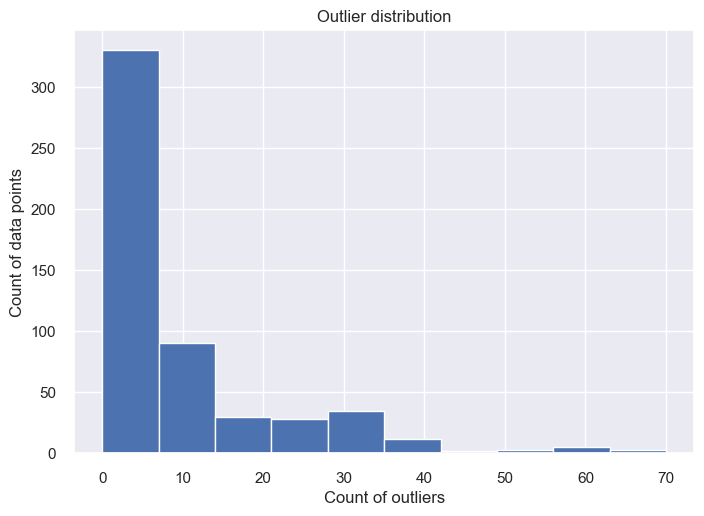

In [247]:
plt.hist(x['Outliers'])
plt.title('Outlier distribution')
plt.xlabel('Count of outliers')
plt.ylabel('Count of data points')
plt.show()

In [248]:
len(x[x['Outliers'] > 40])

13

Most have 0 to 5 outliers, while a very small portion of the features (13 to be exact) have over 40 outliers. These are suspicious and show an obvious visual separation from the other features. Let us look at them more closely.

In [249]:
z = x[x['Outliers'] > 40]
df[(z['Name'])].describe()

,38,139,160,274,295,558,572,573,574,575,576,577,589
count,1566.000000,1553.000000,1565.000000,1553.000000,1565.000000,1566.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1566.000000
mean,86.836577,416.766964,555.346326,136.292426,252.999118,0.995009,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,99.670066
std,0.446756,263.300614,574.808588,85.607784,283.530702,0.083860,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,93.891919
min,84.732700,0.000000,0.000000,0.000000,0.000000,0.891900,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,0.000000
25%,86.578300,243.786000,295.000000,81.215600,130.220300,0.955200,7.500000,0.242250,2.567850,0.075100,1.408450,11.501550,44.368600
50%,86.820700,339.561000,438.000000,110.601400,195.825600,0.972700,8.650000,0.293400,2.975800,0.089500,1.624500,13.817900,71.900500
75%,87.002400,502.205900,625.000000,162.038200,273.952600,1.000800,10.130000,0.366900,3.492500,0.112150,1.902000,17.080900,114.749700
max,88.418800,1770.690900,4170.000000,659.169600,2005.874400,1.512100,454.560000,2.196700,170.020400,0.550200,90.423500,96.960100,737.304800


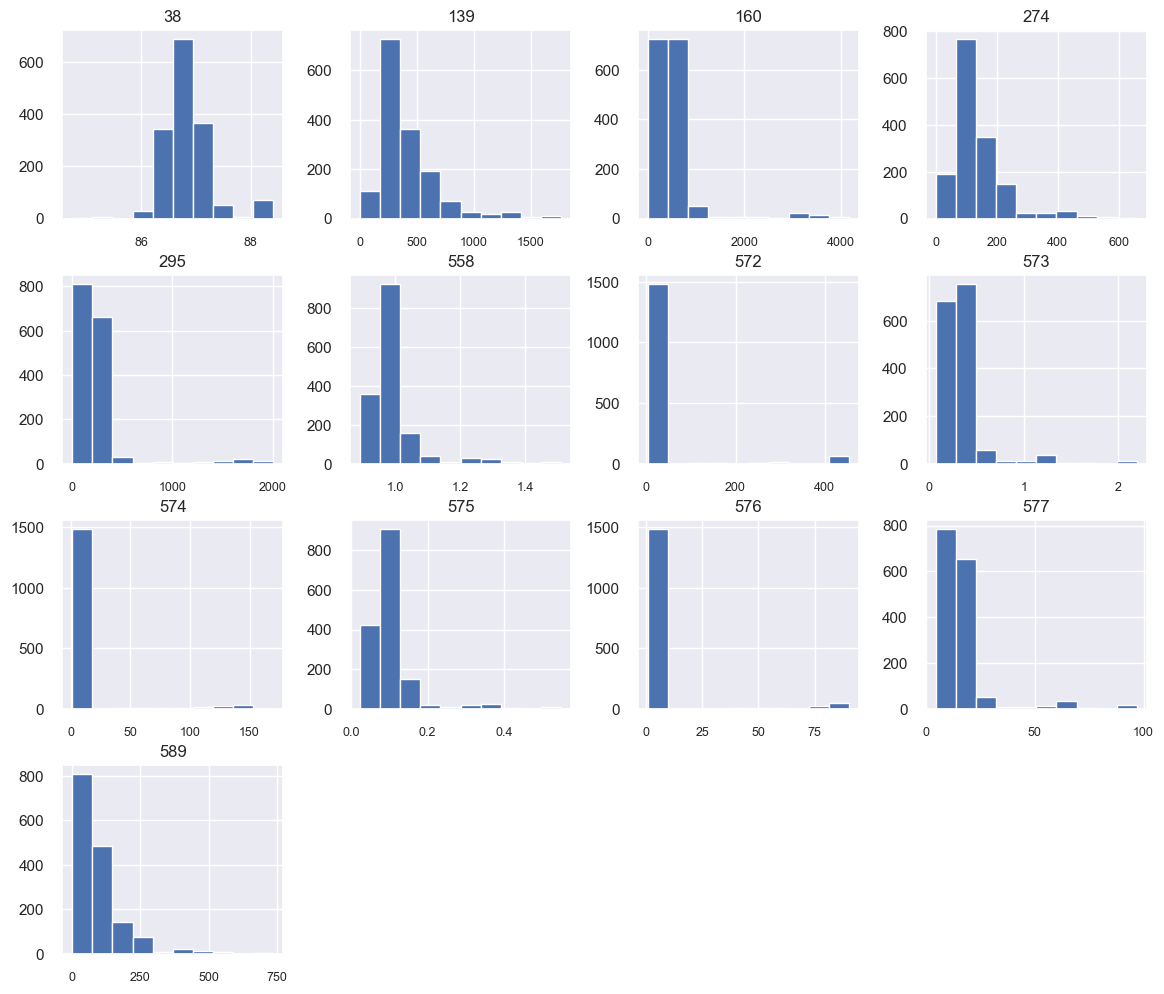

In [250]:
histograms = df[(z['Name'])].hist(figsize=(14,12), xlabelsize = 9)

Looking at these plots visually "I do not like" 160, 295, 572, 573, 574, 575, 576, 577, in fact 6 of these fall in to sequence and it is quite possible that they are connected. In a dataset with fewer features I would not remove such only because of their distribution graph, but here we have no context for each feature, we do not know what feature 160 is or how is it measured. Since here our objective is to reduce the dimensionality of the dataset first we may comfortably remove some of these.

In [251]:
df = df.drop(['160', '295', '572', '573', '574', '575', '576', '577'], axis=1)

I also want to check the relation between number of outliers and number of NaNs (which we still have not imputed). There might be a feature with both a high number of NaNs and outliers. In fact let us sum up the two columns to make a Bad data point column

In [252]:
x['Bad data point'] = x['NaNs'] + x['Outliers']
n = x.sort_values(by = 'Bad data point', ascending=False)
n.head(20)

,Name,Outliers,NaNs,Bad data point
472,496,39,51,90
214,224,25,51,76
343,362,25,51,76
528,576,70,0,70
215,225,18,51,69
526,574,68,0,68
473,497,16,51,67
344,363,15,51,66
38,38,64,1,65
260,274,51,14,65


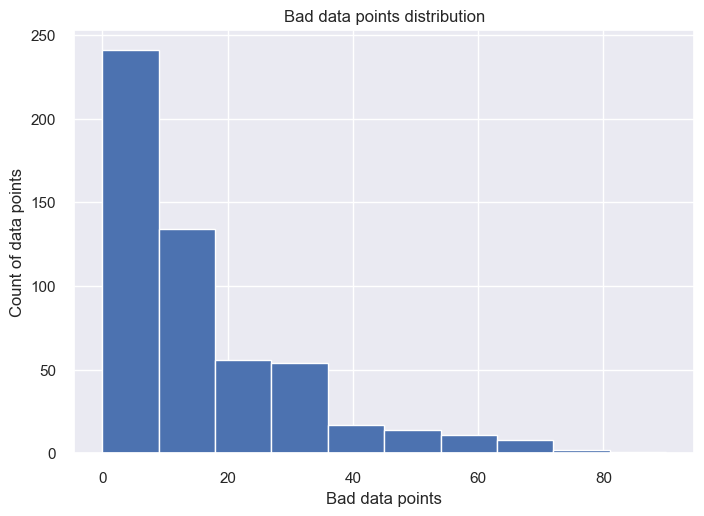

In [253]:
plt.hist(x['Bad data point'])
plt.title('Bad data points distribution')
plt.xlabel('Bad data points')
plt.ylabel('Count of data points')
plt.show()

Sixteen features have >= 60 Bad data points. We already removed 5 of these features in the last step. Currently our dataset has 1567 observations so for such features about 3.8% of the data is either Nan or an outlier. That is ok as a whole, just out of curiosity let us explore there 11 features further.

In [254]:
g = x[~x['Name'].isin(['160', '295', '572', '573', '574', '575', '576', '577'])]
h = g[g['Bad data point'] >= 60]
df[(h['Name'])].describe()

,38,90,139,224,225,274,362,363,483,496,497
count,1566.000000,1516.000000,1553.000000,1516.000000,1516.000000,1553.000000,1516.000000,1516.000000,1543.000000,1516.000000,1516.000000
mean,86.836577,8827.536865,416.766964,0.059370,1041.056588,136.292426,0.018383,333.319601,206.564196,29.865896,11.821030
std,0.446756,396.313662,263.300614,0.071211,433.170076,85.607784,0.021644,138.801928,192.864413,24.621586,4.956647
min,84.732700,7397.310000,0.000000,0.009300,168.799800,0.000000,0.002800,60.988200,0.000000,4.813500,1.949600
25%,86.578300,8564.689975,243.786000,0.029775,718.725350,81.215600,0.009500,228.682525,81.316150,16.342300,8.150350
50%,86.820700,8825.435100,339.561000,0.039800,967.299800,110.601400,0.012500,309.831650,148.317500,22.039100,10.906550
75%,87.002400,9065.432400,502.205900,0.061300,1261.299800,162.038200,0.018600,412.329775,262.865250,32.438475,14.469050
max,88.418800,10746.600000,1770.690900,1.436100,3601.299800,659.169600,0.416300,1072.203100,989.473700,219.643600,40.281800


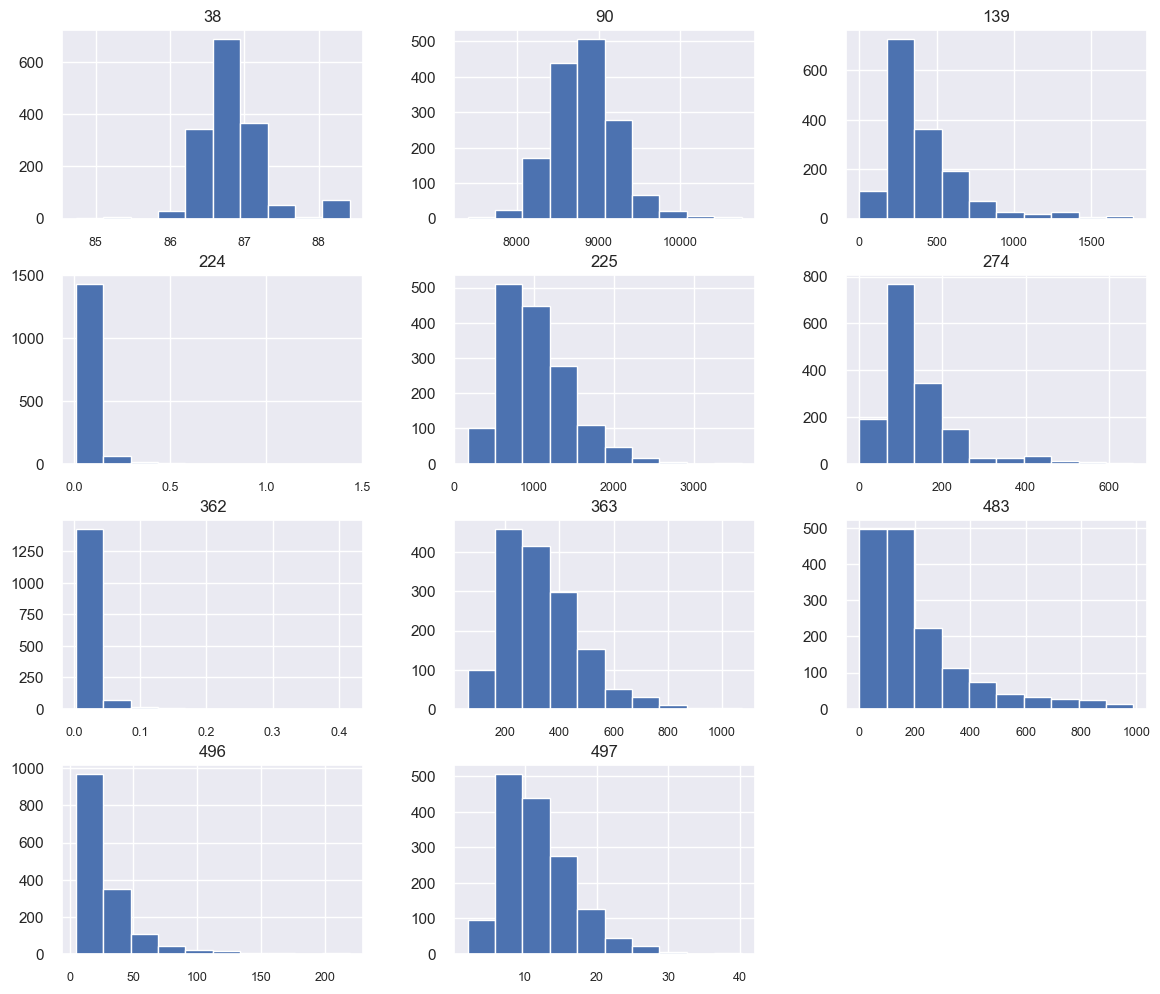

In [255]:
histograms = df[(h['Name'])].hist(figsize=(14,12), xlabelsize = 9)

I believe that the imputation of NaNs and Outliers should suffice for these 11, no need to remove the whole features

#### Train/Test split and impute NaNs and Outliers
Now that we have removed unnecessary features we are left with the imputation of the outliers and NaNs. Notice that we defined the outlier based on the whole dataset, which is better then doing is separately on the train and test dataset. However the imputation of these values should be done separately for the train and test datasets in order to avoid data leakage from one to the other.

Impute outliers with the mean separately for the train and test datasets
Fit and apply a `KNNImputer` separately for the train and test datasets
This way the transformations are independent for the two datasets.

In [256]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

In the `train_test_split` we set the `stratify` on the target, to account for the imbalance in the Pass/Fail column

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67, stratify=y)

Text(0.5, 0, '1: Fail, 0: Pass')

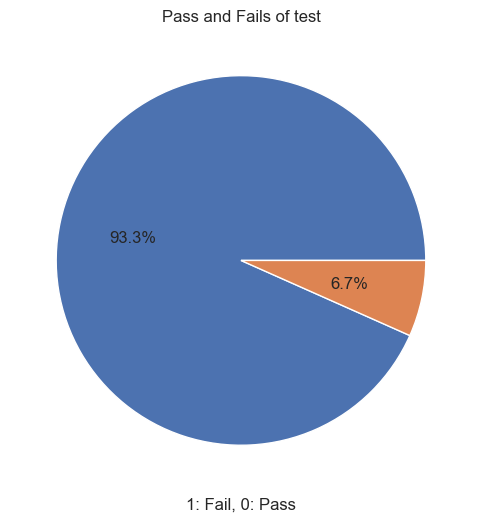

In [258]:
plt.figure(figsize=(10,6))
plt.pie(y_train.value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

Text(0.5, 0, '1: Fail, 0: Pass')

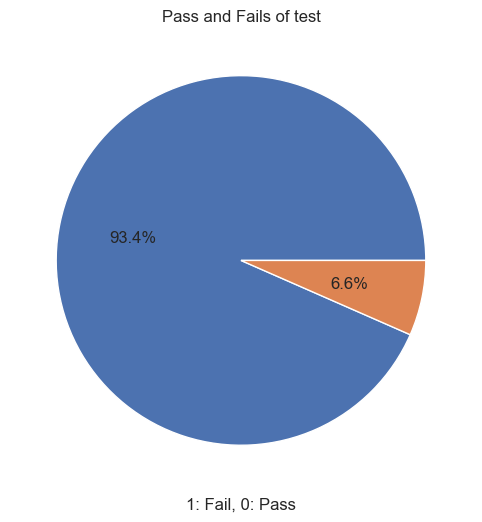

In [259]:
plt.figure(figsize=(10,6))
plt.pie(y_test.value_counts(),autopct='%1.1f%%')
plt.title("Pass and Fails of test")
plt.xlabel('1: Fail, 0: Pass')

In [260]:
def outlier_imputer(df_whole, df_impute, columns, n_std):
    '''Impute outliers with the mean for all columns in a dataset, which keeping NaN values'''
    for column in columns:
        '''Mean and SD are defined by the whole dataset'''
        mean = df_whole[column].mean()
        sd = df_whole[column].std()
    
        '''Outliers are replaced with the mean for the fit dataset train or test respectively'''
        df_impute[column] = np.where(df_impute[column] > mean+(n_std*sd), df_impute[column].mean(), df_impute[column])

    return df_impute

In [261]:
X_train = outlier_imputer(df, X_train, X_train.columns, 3)
X_test = outlier_imputer(df, X_test, X_test.columns, 3)

In [262]:
def nan_imputer(df):
    '''Impute NaNs on the whole dataset using KNNImputer'''
    imputer = KNNImputer()
    imputer.fit(df)

    df = pd.DataFrame(imputer.transform(df), columns=df.columns)

    return df
    

In [263]:
X_train = nan_imputer(X_train)
X_test = nan_imputer(X_test)

In [264]:
np.count_nonzero(X_train.isna().sum())

0

In [265]:
np.count_nonzero(X_test.isna().sum())

0

#### Balance the train data

I would like to balance the train data using the `SMOTE` method. Synthetic minority Oversampling Technique (SMOTE) is a method of oversampling that generates additional data points of the minority class (the fails in our case). This is based on the nearest neighbors to the existing fails, so the generated data points are not exact copies.

In [266]:
method = SMOTE()
X_train_balanced, y_train_balanced = method.fit_resample(X_train, y_train)

### Dimension reduction
#### Principle Component Analysis (PCA)  

No let us apply the principle component analysis to the dataset. Since PCA is affected by scale, we need to scale the features in the data before applying PCA. We can transform the data onto unit scale (`mean = 0` and `SD = 1`), which is a requirement for the optimal performance of many machine learning algorithms. `StandardScaler` helps standardize the data set’s features. We fit on the training set and transform on the training and test set.

In [36]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train_balanced)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

Let us have a look at the result of the scaling

In [37]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,520,521,522,523,524,525,526,527,528,529
count,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2046.0,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,...,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03,2.046000e+03
mean,-1.403027e-15,-2.130586e-15,-1.774620e-15,5.400264e-16,-1.215493e-16,0.0,-1.236330e-15,-1.493321e-15,3.076935e-15,-5.643362e-18,...,2.073285e-15,6.945677e-16,1.321762e-14,-6.251109e-17,-3.472838e-16,-4.861974e-17,5.556541e-17,2.700132e-16,-1.041852e-16,-1.979518e-16
std,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,0.0,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,...,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00
min,-3.736846e+00,-4.881930e+00,-5.446064e+00,-1.985532e+00,-1.751612e+00,0.0,-3.547858e+00,-1.779866e+01,-4.246837e+00,-3.907911e+00,...,-1.036022e+01,-3.797802e+00,-6.918580e+00,-1.853762e+00,-2.014220e+00,-1.855097e+00,-3.629533e+00,-1.947172e+00,-1.900531e+00,-1.463764e+00
25%,-6.720535e-01,-5.133759e-01,-6.950161e-01,-7.967799e-01,-6.730352e-01,0.0,-4.732384e-01,-1.274354e-01,-6.386081e-01,-5.955871e-01,...,5.320526e-02,-3.853282e-01,-6.557007e-01,-6.909415e-01,-6.926079e-01,-6.820974e-01,-7.119050e-01,-7.404365e-01,-7.624244e-01,-6.931846e-01
50%,-1.109293e-01,7.572374e-02,-1.362709e-02,-1.660662e-01,-4.831412e-02,0.0,5.129867e-02,4.669114e-02,-1.385165e-03,-2.544974e-02,...,1.306697e-01,1.206962e-01,1.750619e-02,-1.740968e-01,-1.524879e-01,-1.656465e-01,3.199777e-03,-1.521532e-01,-1.716841e-01,-2.652437e-01
75%,5.926623e-01,5.674982e-01,6.156224e-01,5.961878e-01,4.751310e-01,0.0,5.430103e-01,2.426244e-01,6.974605e-01,5.500385e-01,...,2.289306e-01,6.883376e-01,6.329917e-01,3.774114e-01,3.656900e-01,3.796481e-01,6.038878e-01,5.793364e-01,5.551328e-01,2.984667e-01
max,3.212453e+00,3.482121e+00,3.174296e+00,3.962950e+00,8.372999e+00,0.0,3.352496e+00,8.126723e-01,2.981726e+00,3.317612e+00,...,2.015676e+00,2.255174e+00,2.892822e+00,6.530784e+00,5.915454e+00,6.412447e+00,3.550120e+00,3.679230e+00,3.744476e+00,4.681838e+00


In [38]:
pca_095 = PCA(0.95)
pca_095 = pca_095.fit(X_train_scaled)
pca_095.n_components_

156

We see that when we set the variance explained to be 95% of the datasets initial variance we see that the 530 features are compressed in 156 components, which means that we have reduced the dimensionality about 3 times. But are all these components meaningful? Lets look at the variance explained per feature.  

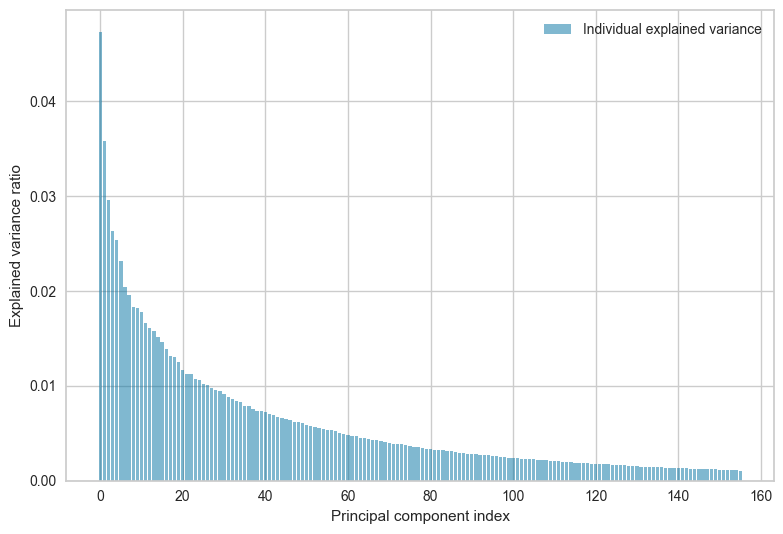

In [39]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

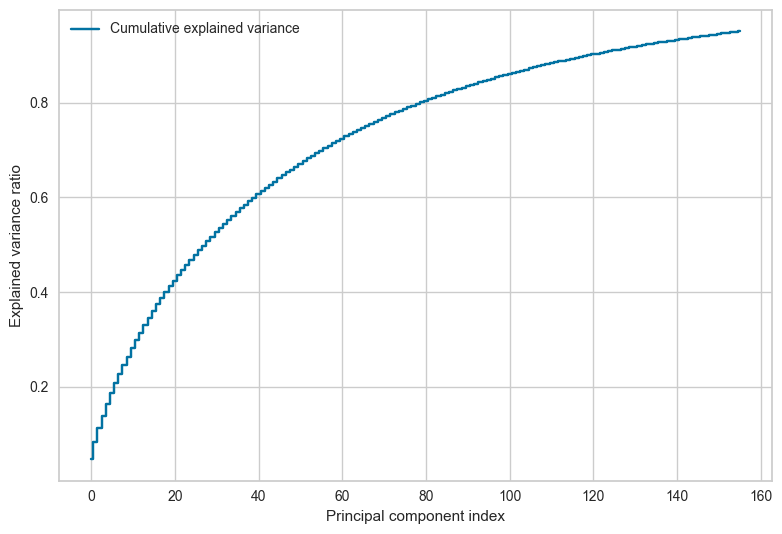

In [40]:
exp_var_pca = pca_095.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We see from the two graphs that even though the first 3 components are strong predictors (they explain more variance the the succeeding), as percentages this is between 4 and 2%, which is not much. The components gradually decrees in explainability, which is to be expected, but there is no visually distinguishable threshold, after which we may disregard some of the components.       

So lets `fit_transform` the dataset using the 95% PCA

In [41]:
X_train_pca_095 = pca_095.fit_transform(X_train_scaled)
X_train_pca_095 = principalDF=pd.DataFrame(data=X_train_pca_095)

Just for arbitrary testing let us state that components with variance explained below 0.5% are to be ignored. Visually this coincides with the 75th component. So let us apply the `PCA(n_components = 75) ` and save it separately.

In [42]:
pca_75 = PCA(n_components=75)
X_train_pca_75 = pca_75.fit_transform(X_train_scaled)
X_train_pca_75 = principalDF=pd.DataFrame(data=X_train_pca_75)
X_test_pca_75 = pca_75.fit_transform(X_test_scaled)
X_test_pca_75 = principalDF=pd.DataFrame(data=X_test_pca_75)

##### Modeling PCA data
Now let us get to the gist of things, which is to model the dimensionally reduced data. As mentioned we will try three classifiers (LogReg, RF, GBM and AdaBoost) and as estimator we need a metric that works well on an imbalanced dataset as we saw earlier. I will use the `f1_score` and `matthews_corrcoef`.   

In [43]:
def evaluate(train_df, test_df, train_target, test_target, estimator):
    
    # first, we should scale our data so logistic regression works better
    
    # training the model
    start_time = time.time()
    method = SMOTE()
    train_df, train_target = method.fit_resample(train_df, train_target)
    estimator.fit(train_df, train_target)
    runtime = time.time() - start_time
    
    # evaluation and scoring
    y_pred = estimator.predict(test_df)
    y_true = test_target
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(estimator, classes=['pass','fail'])
    cre.score(test_df, y_true)
    cre.show()
    cm = ConfusionMatrix(estimator, classes=['pass','fail'])
    cm.score(test_df, y_true)
    cm.show()
    rocauc = RocCurveDisplay.from_estimator(estimator, test_df, y_true)
    plt.show()
    
    return f'Run time: {runtime}, F1-score: {f1score}, MCC: {mccscore}' 

Just to have a benchmark let us look at the results for the dataset without any prior transformation. 

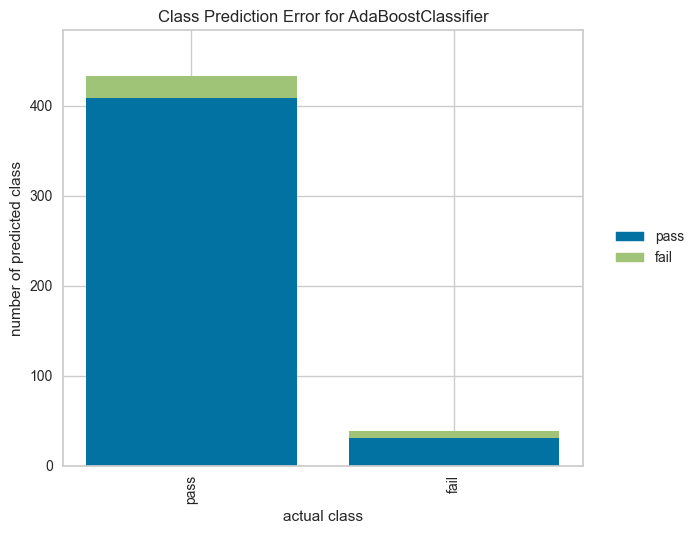

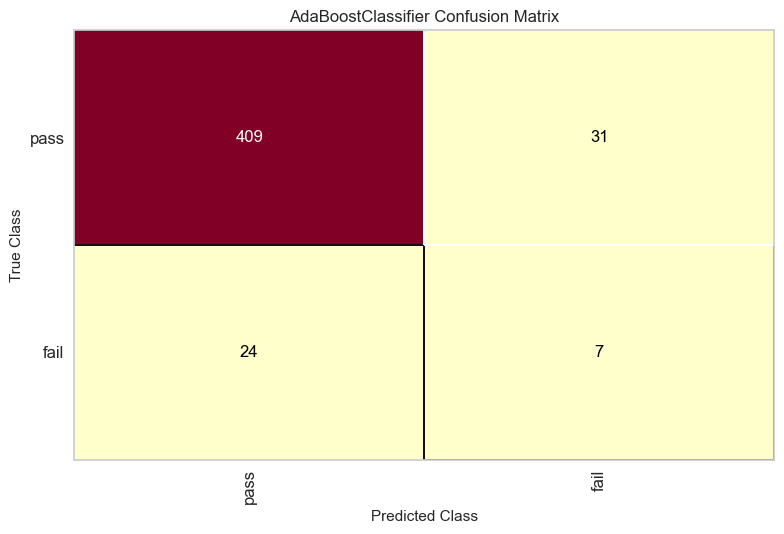

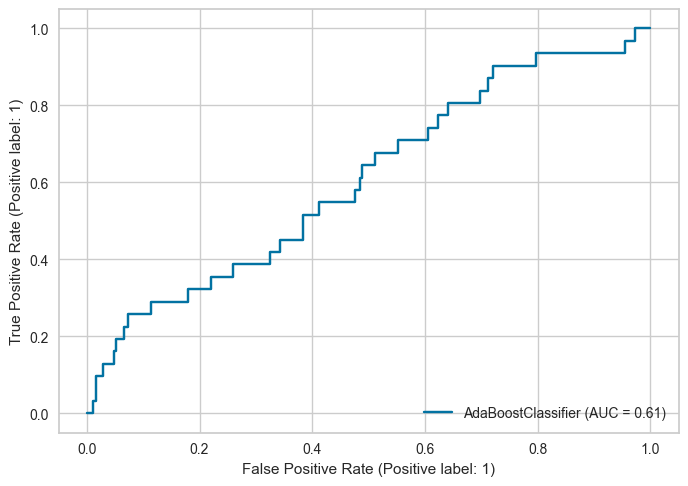

'Run time: 15.867219686508179, F1-score: 0.8832271762208068, MCC: 0.1414451384385165'

In [44]:
evaluate(X_train, X_test, y_train, y_test, AdaBoostClassifier(random_state=34))

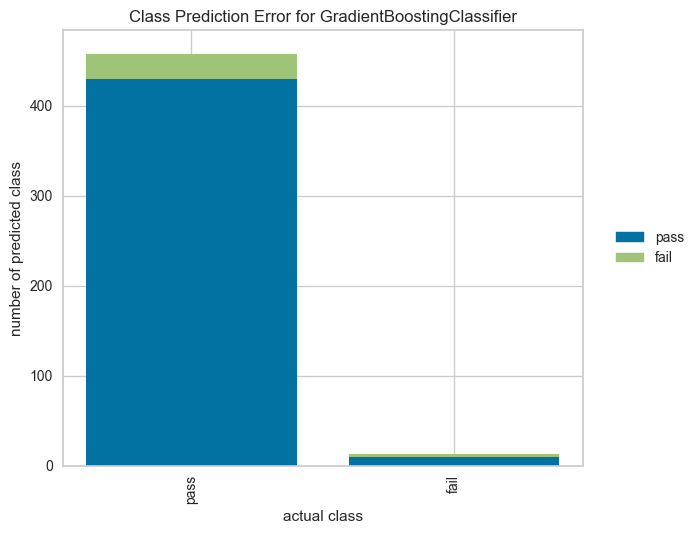

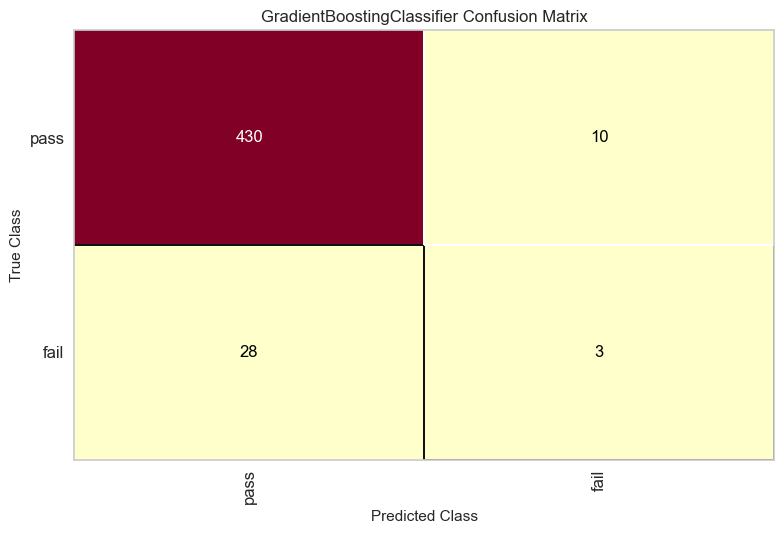

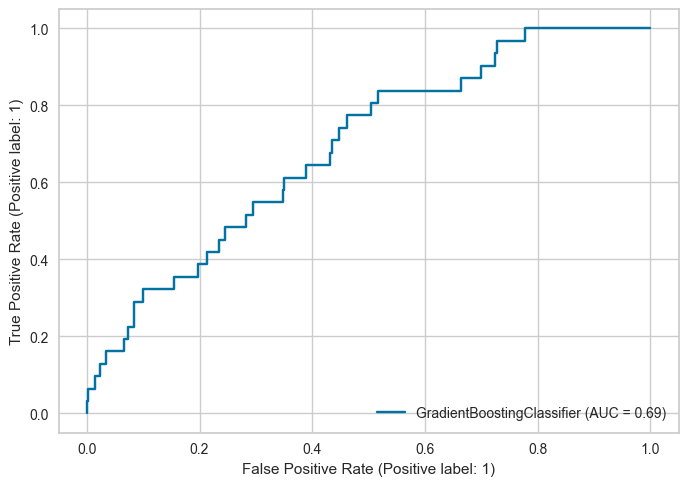

'Run time: 87.50144910812378, F1-score: 0.9193205944798302, MCC: 0.11207526475389179'

In [45]:
evaluate(X_train, X_test, y_train, y_test, GradientBoostingClassifier(random_state=34))

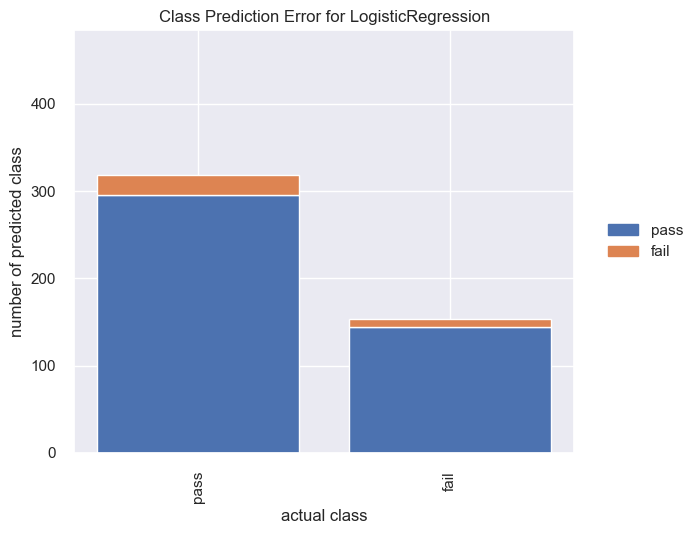

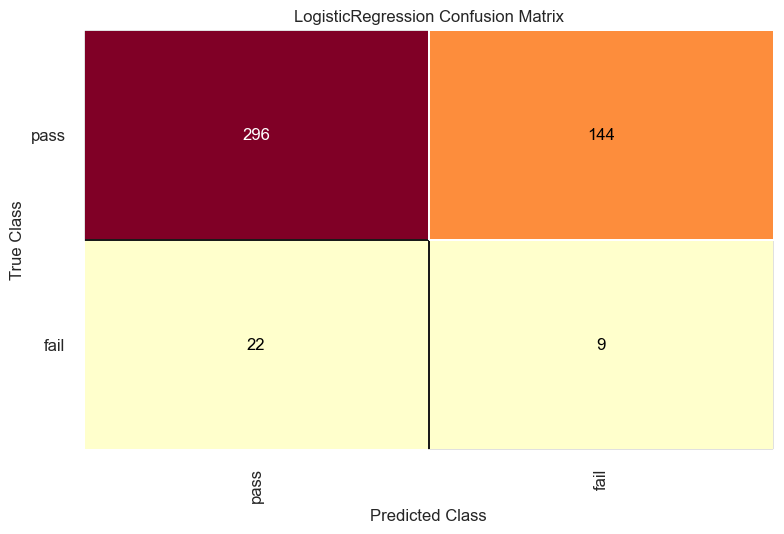

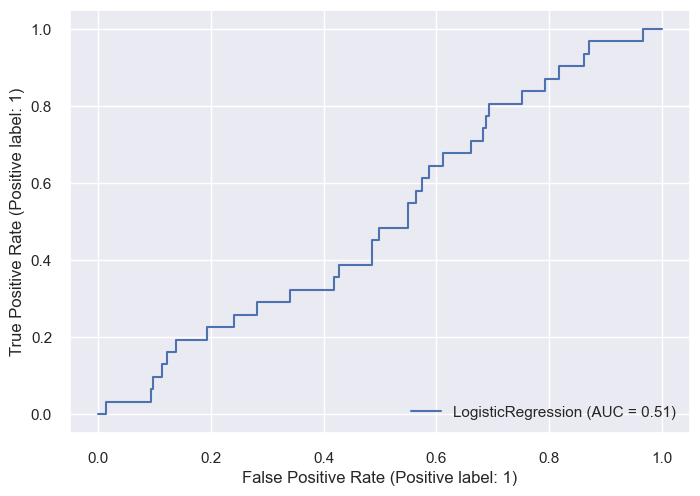

'Run time: 0.3730590343475342, F1-score: 0.6475583864118896, MCC: -0.01956428928701219'

In [126]:
evaluate(X_train, X_test, y_train, y_test, LogisticRegression(random_state=34))

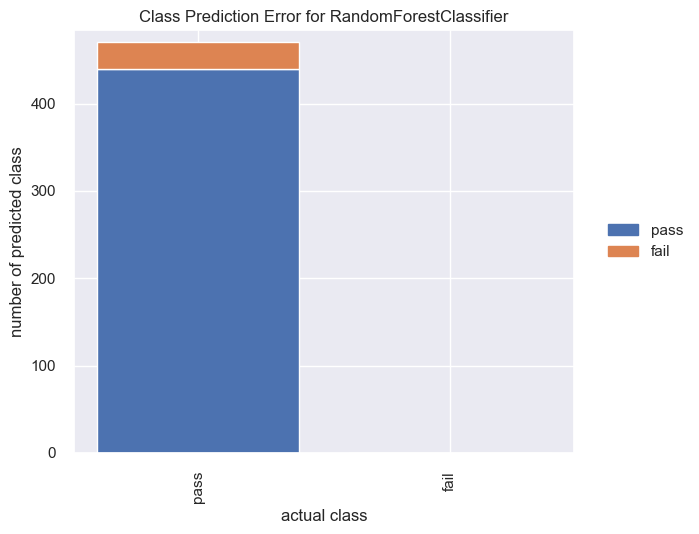

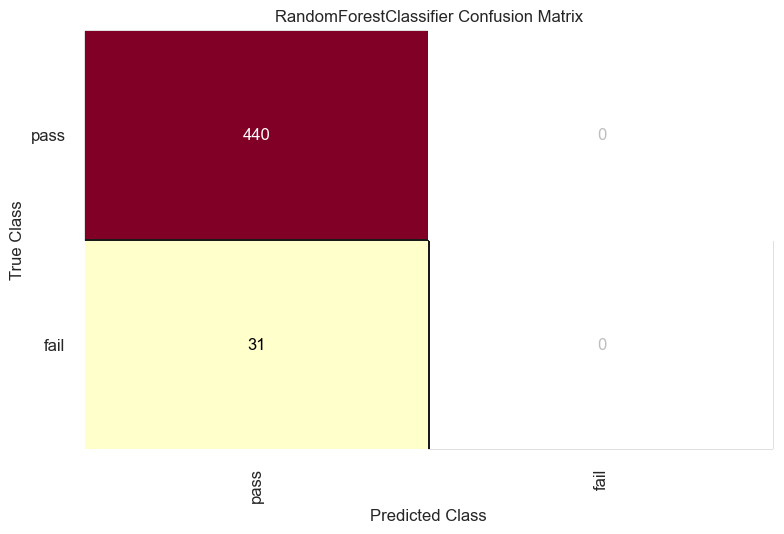

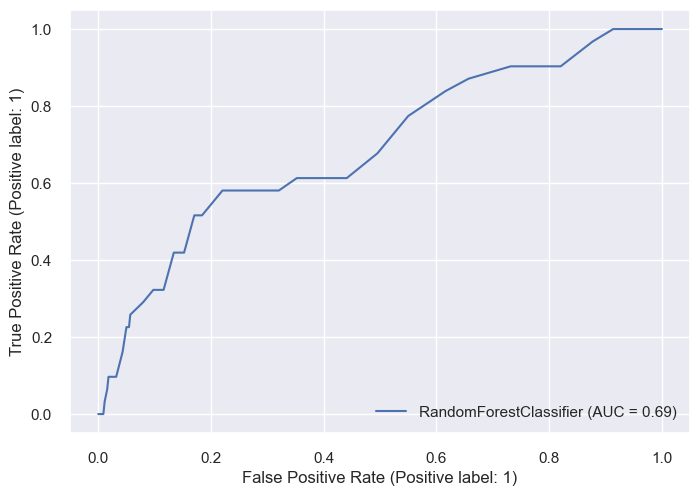

'Run time: 12.310892343521118, F1-score: 0.9341825902335457, MCC: 0.0'

In [127]:
evaluate(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=34))

We can see that all models have a hard time predicting the fails, especially the `RandomForestClassifier`, which simply predicts that all conductors will pass. 

In [46]:
pca_95_for_test = PCA(n_components=156)
X_test_pca_095 = pca_95_for_test.fit_transform(X_test_scaled)

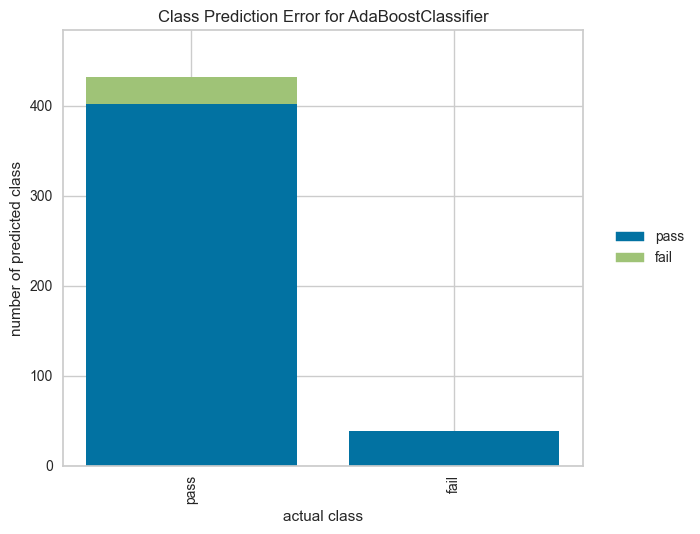

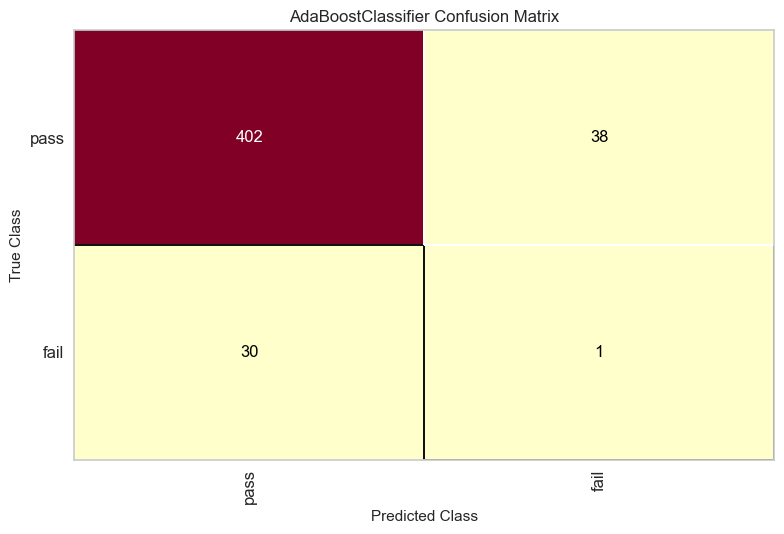

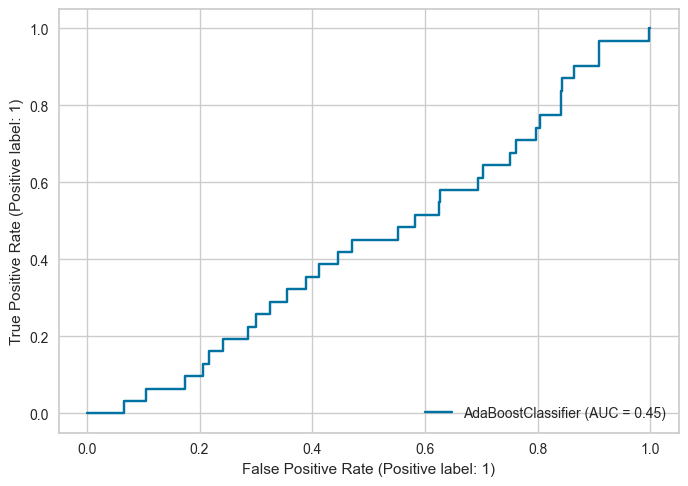

'Run time: 7.662032842636108, F1-score: 0.8556263269639066, MCC: -0.048682738452503156'

In [47]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, AdaBoostClassifier(random_state=34))

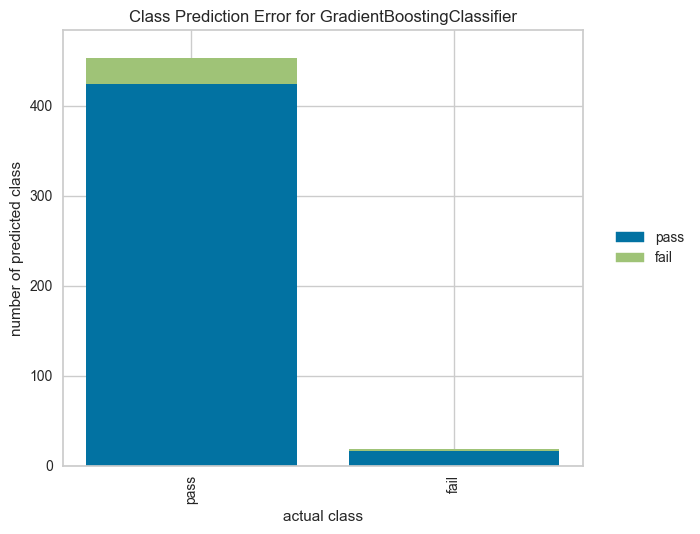

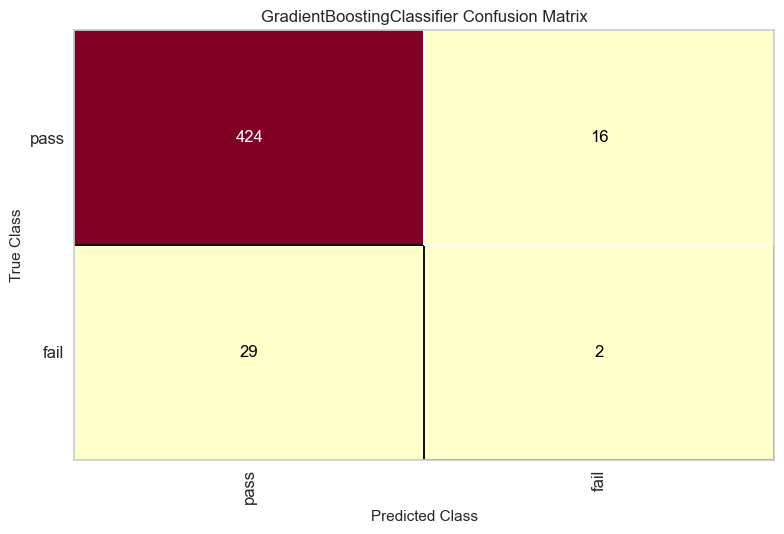

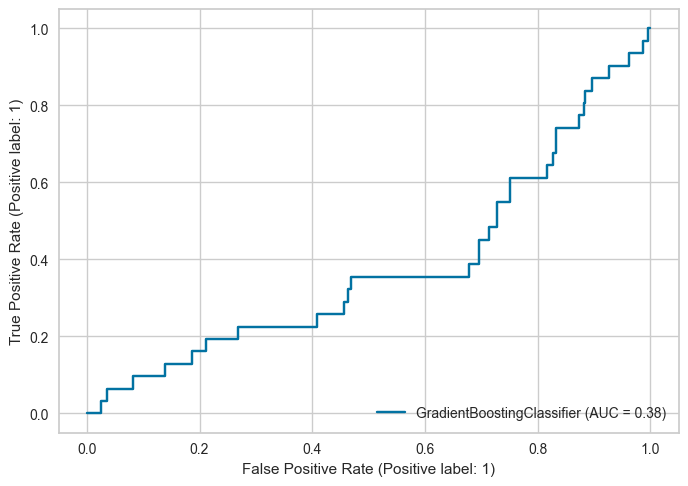

'Run time: 41.17690849304199, F1-score: 0.9044585987261147, MCC: 0.03641150966250527'

In [48]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, GradientBoostingClassifier(random_state=34))

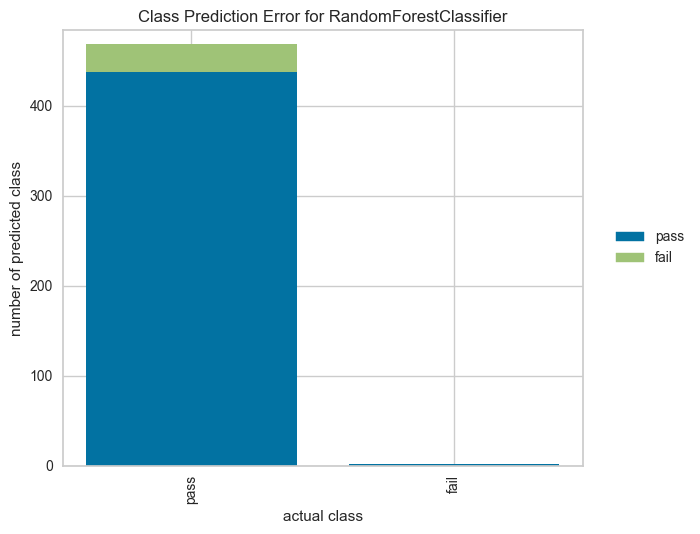

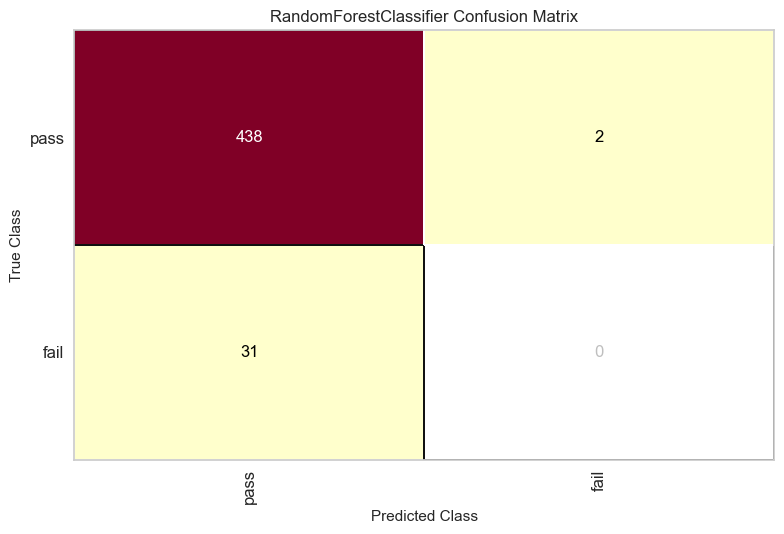

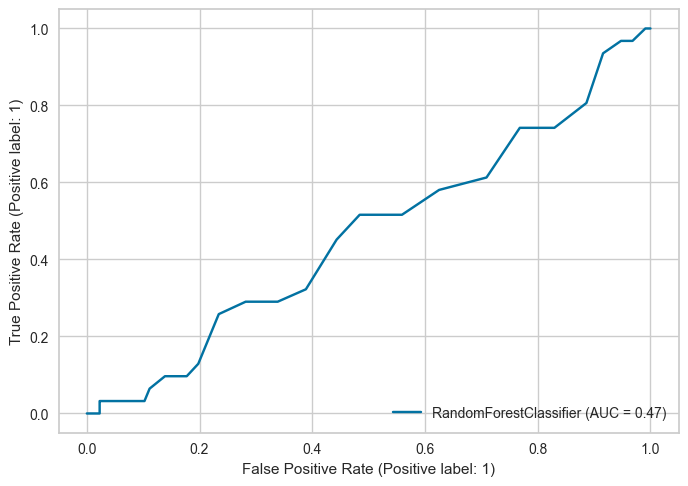

'Run time: 8.214124202728271, F1-score: 0.9299363057324841, MCC: -0.017333373094521518'

In [49]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, RandomForestClassifier(random_state=34))

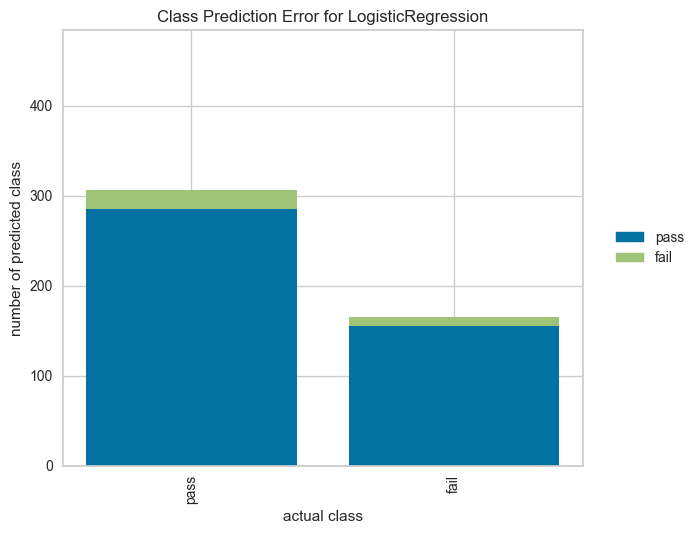

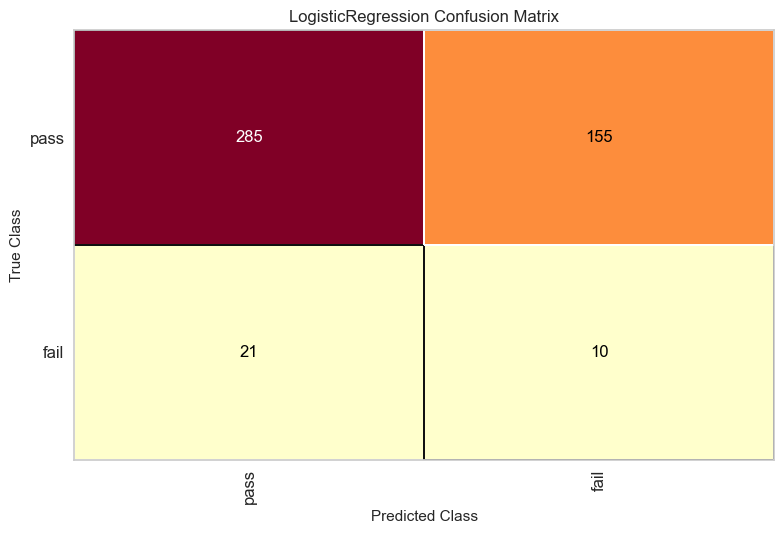

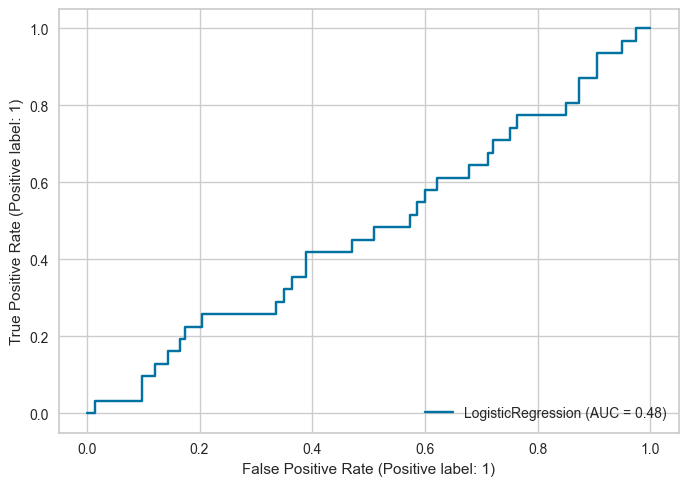

'Run time: 0.1268320083618164, F1-score: 0.6263269639065817, MCC: -0.015432815091309244'

In [50]:
evaluate(X_train_pca_095, X_test_pca_095, y_train_balanced, y_test, LogisticRegression())

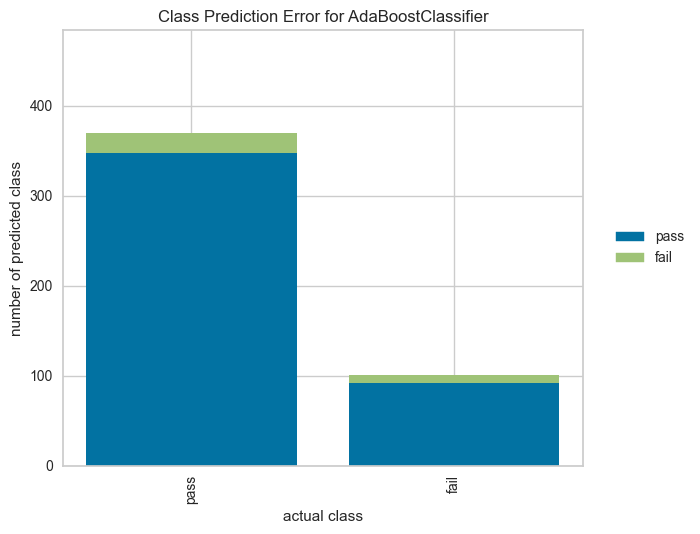

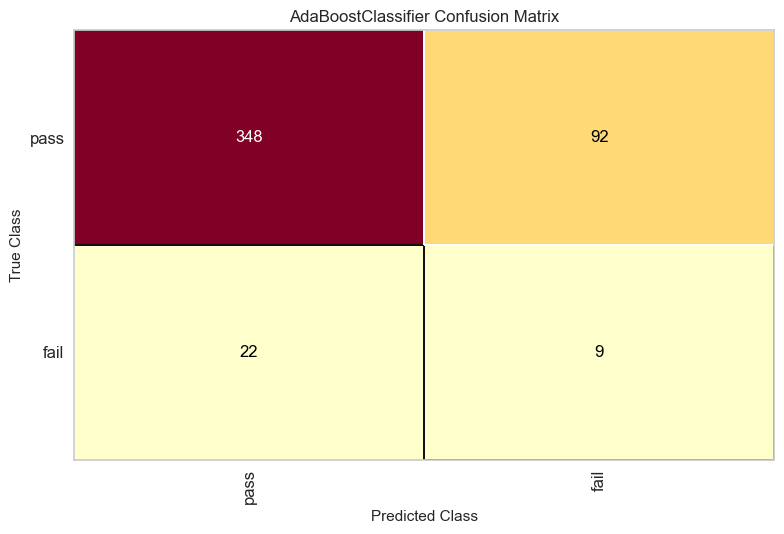

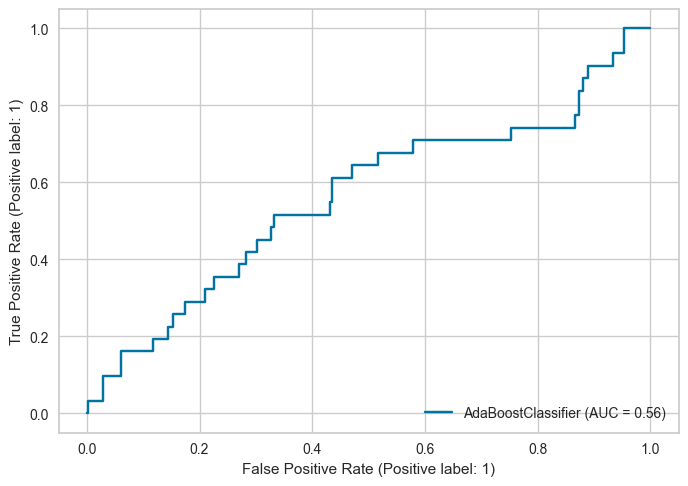

'Run time: 3.7856807708740234, F1-score: 0.7579617834394905, MCC: 0.04907621114611327'

In [51]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, AdaBoostClassifier(random_state=34))

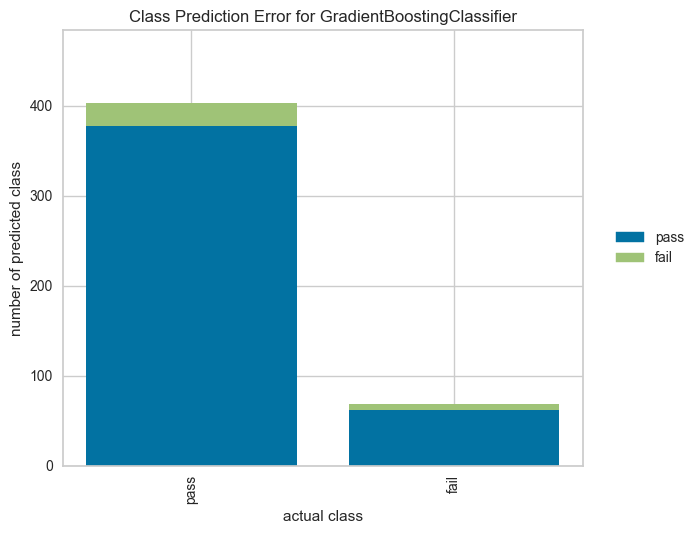

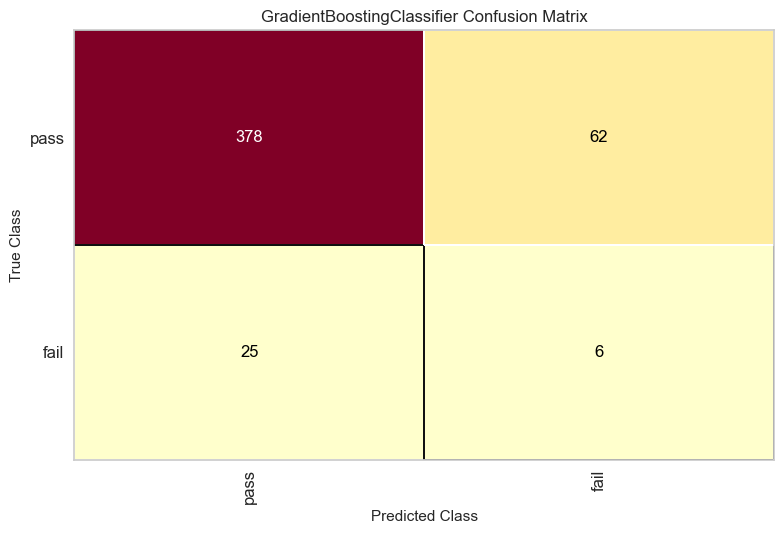

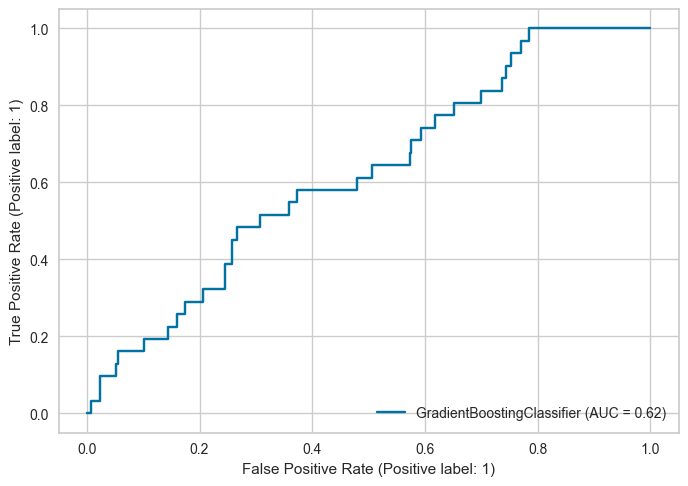

'Run time: 20.13497304916382, F1-score: 0.8152866242038217, MCC: 0.03713729604072355'

In [52]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, GradientBoostingClassifier(random_state=34))

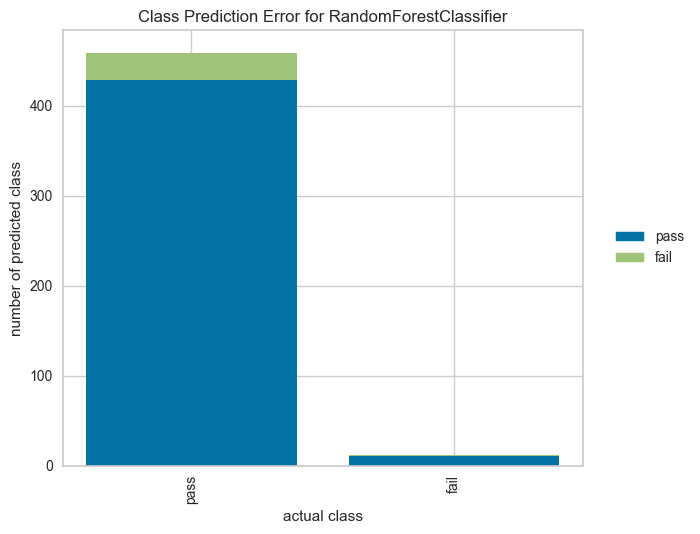

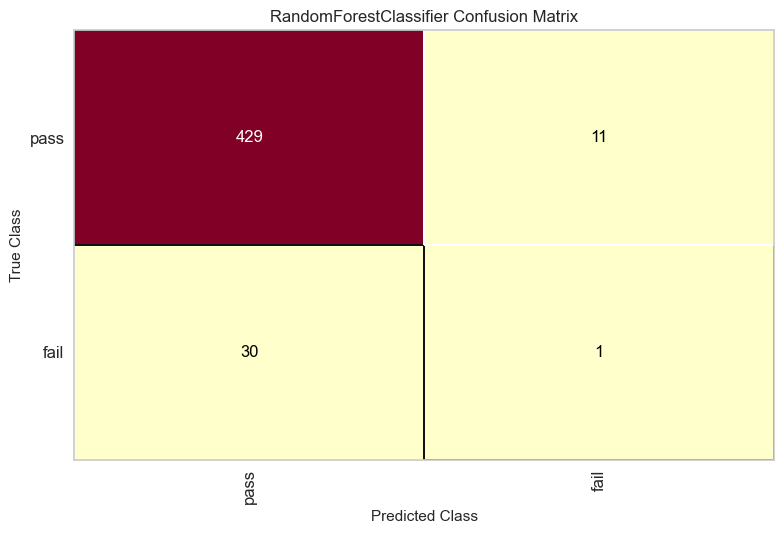

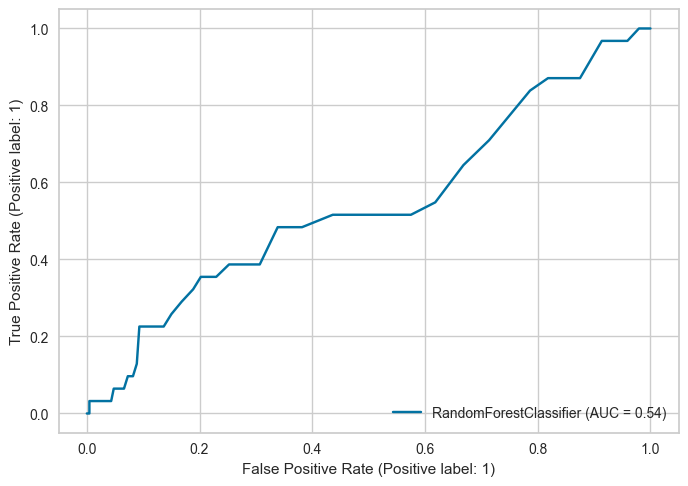

'Run time: 6.32724666595459, F1-score: 0.9129511677282378, MCC: 0.011421707751892423'

In [53]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, RandomForestClassifier(random_state=34))

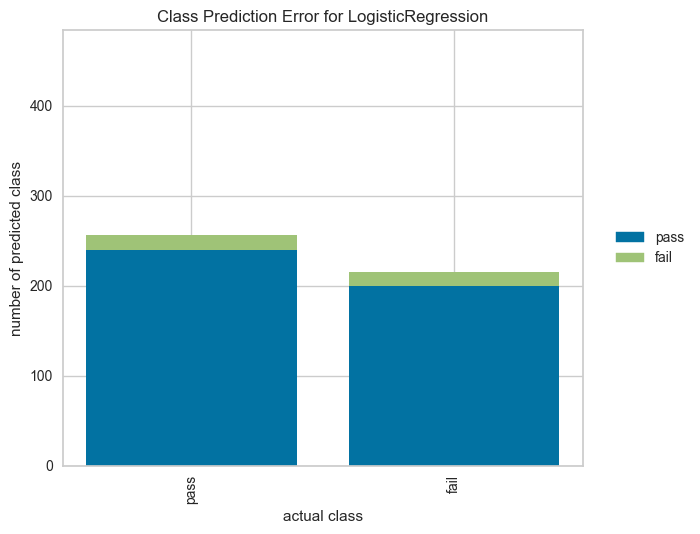

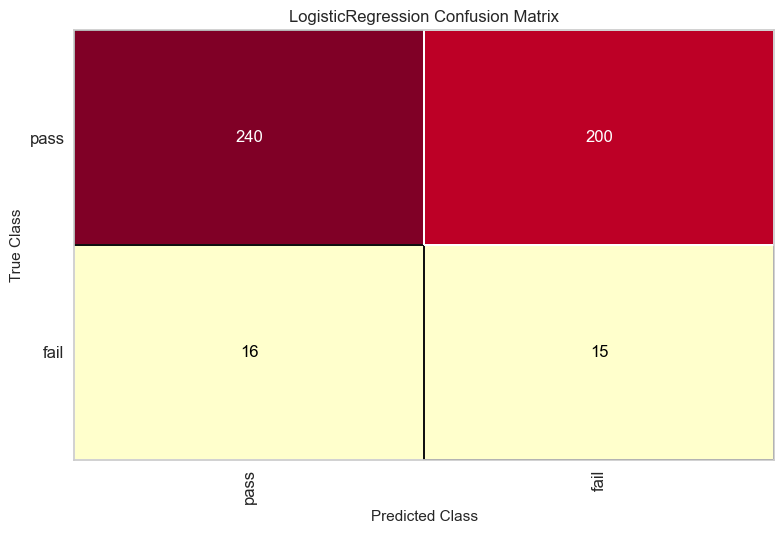

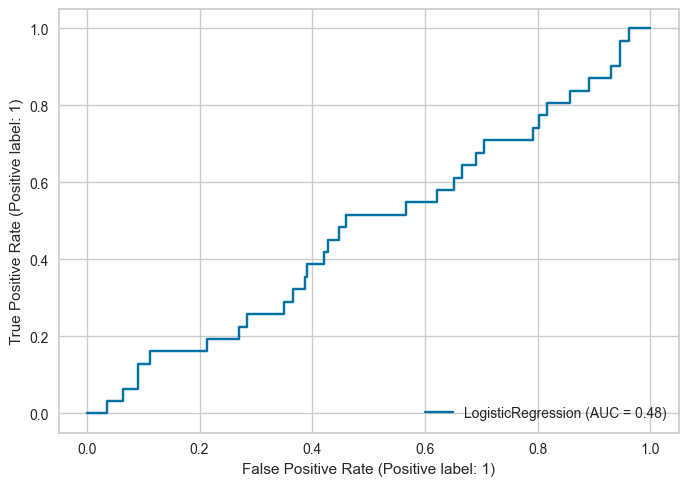

'Run time: 0.05773425102233887, F1-score: 0.5414012738853503, MCC: 0.014598680152114017'

In [54]:
evaluate(X_train_pca_75, X_test_pca_75, y_train_balanced, y_test, LogisticRegression())

Not off to a great start when using the two PCA datasets. The `LogisticRegression` splits the data in almost 50/50, while the other models predict the passes well, but have a very poor performance for the fail class. 

#### Singular vector decomposition (SVD)

This method is quite similar to the PCA, it even has similar attributes and parameters. Again let us first scale the dataset.

In [55]:
svd = TruncatedSVD(algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.08307508392798142

Be default the SVD generates 2 components and we see that gives us an explained variance of 8.3%, which is close to the PCA, remember that the first two components of the PCA had a variance explained ration of 4 and 3.5%. Gradually increasing the `n_components` I decided to stop at 120. 

In [128]:
svd = TruncatedSVD(n_components=120, algorithm='arpack', random_state=23)
svd.fit_transform(X_train_scaled)
svd.explained_variance_ratio_.sum()

0.8998950711906415

Let us go ahead and use a svd with 120 components, since it explains about 90% of the variance

In [57]:
svd = TruncatedSVD(n_components=120, algorithm='arpack', random_state=23)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.fit_transform(X_test_scaled)

##### Modeling the SVD data

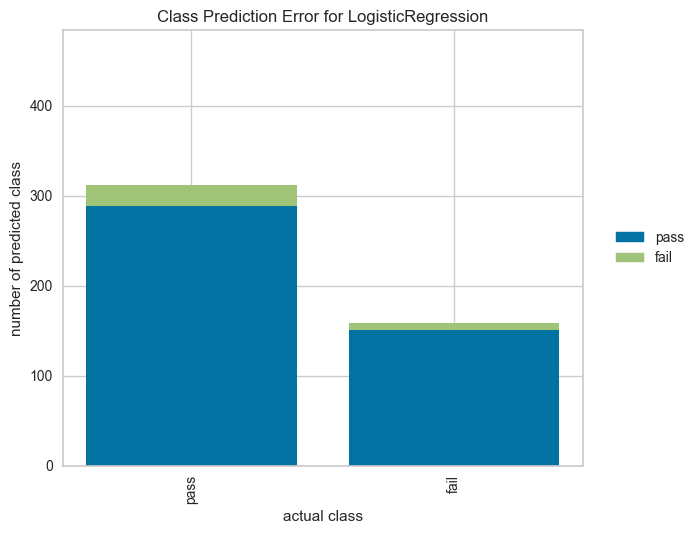

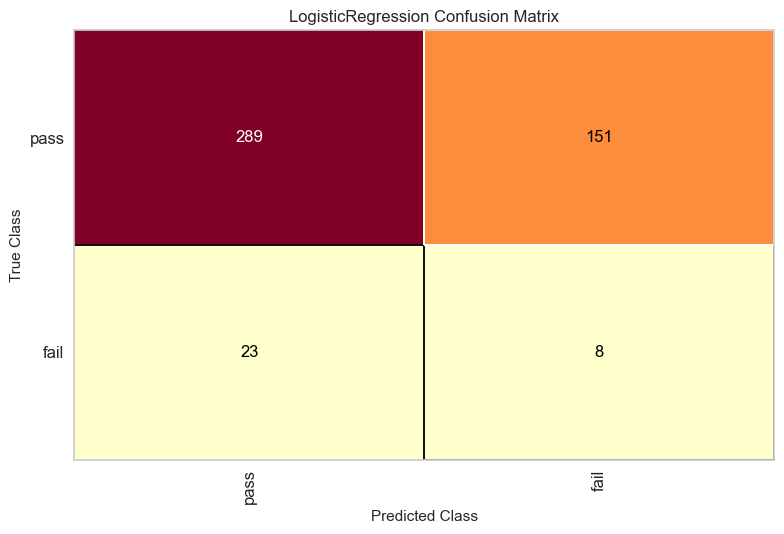

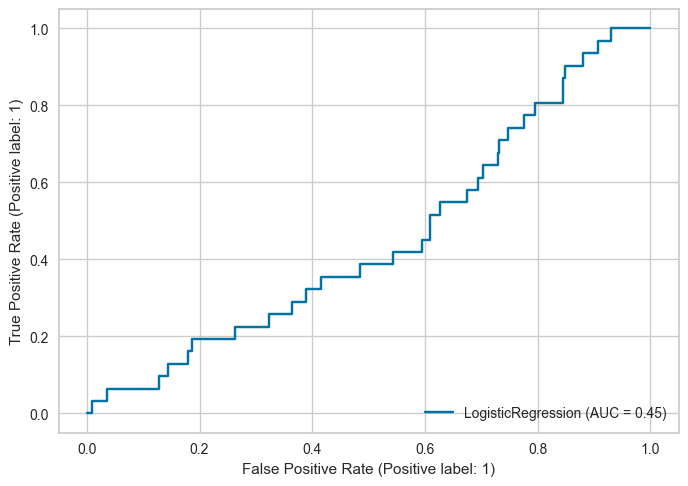

'Run time: 0.08744168281555176, F1-score: 0.6305732484076433, MCC: -0.04463229052952265'

In [58]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, LogisticRegression())

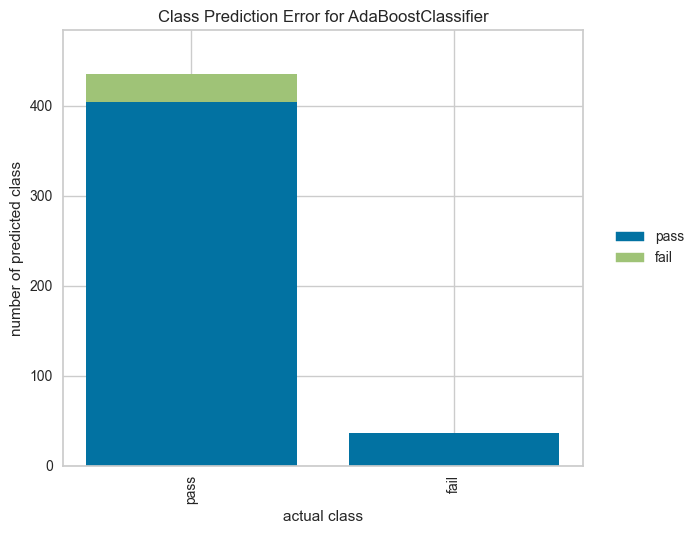

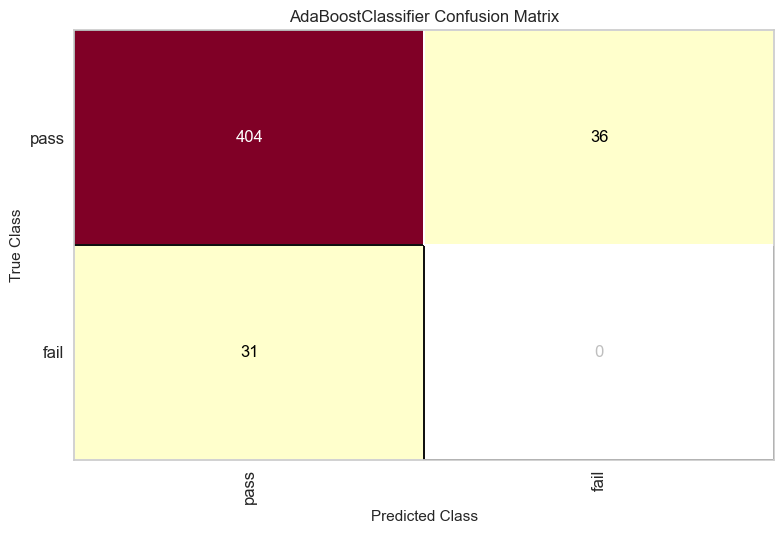

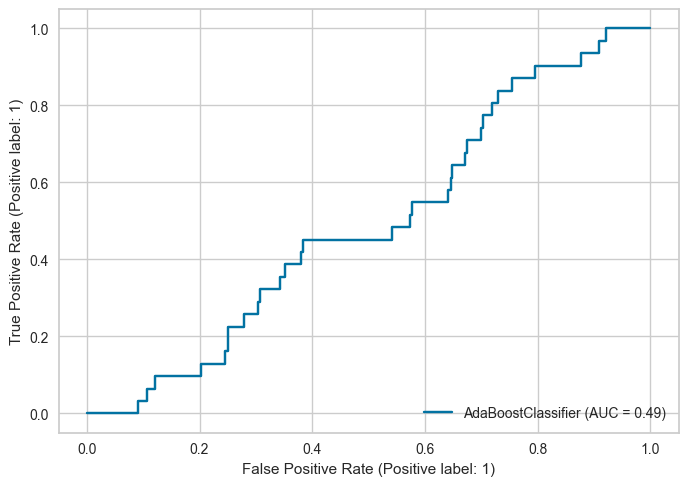

'Run time: 5.9497740268707275, F1-score: 0.8577494692144374, MCC: -0.07635915795197584'

In [59]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, AdaBoostClassifier())

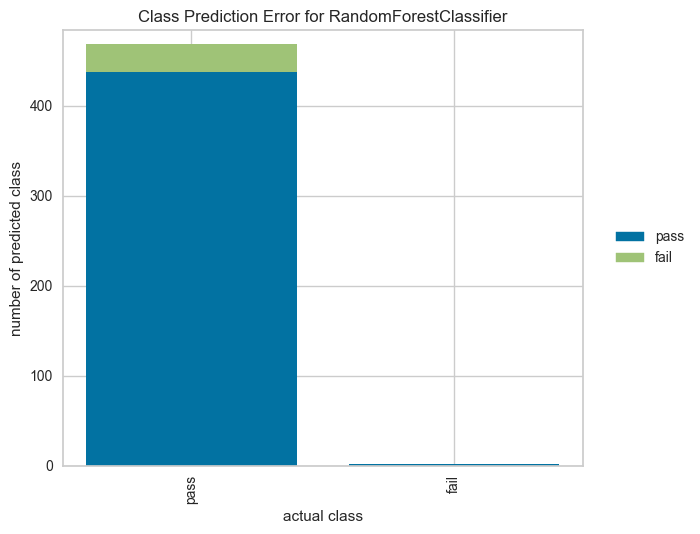

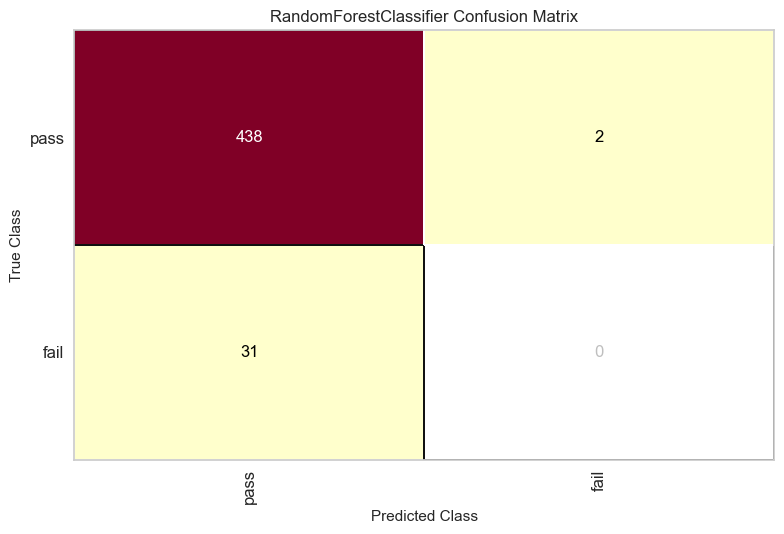

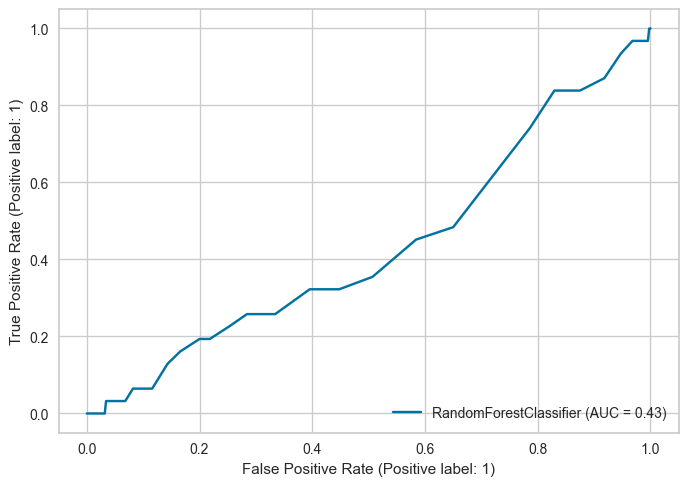

'Run time: 7.791699171066284, F1-score: 0.9299363057324841, MCC: -0.017333373094521518'

In [60]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, RandomForestClassifier())

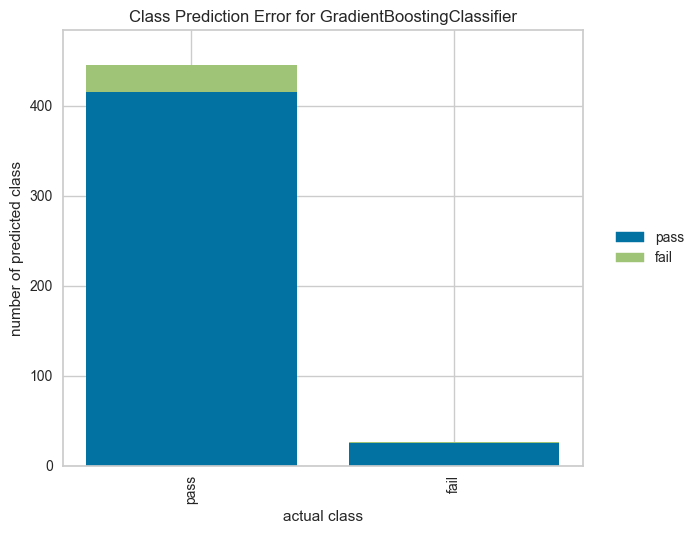

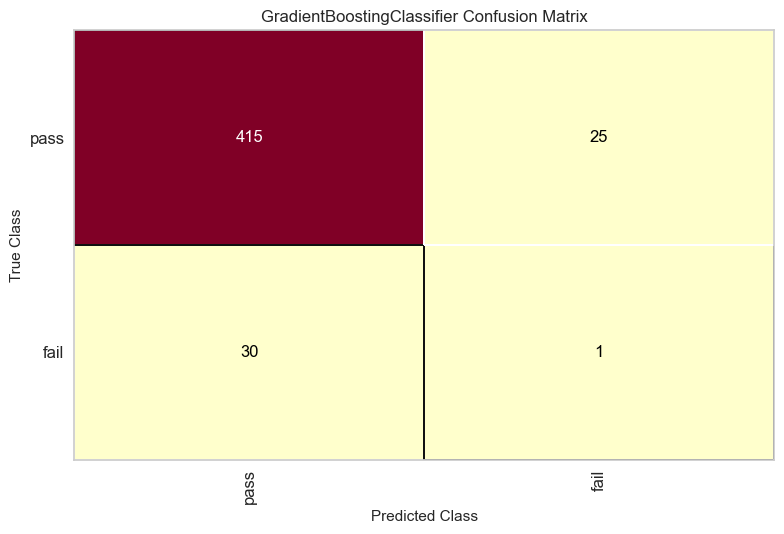

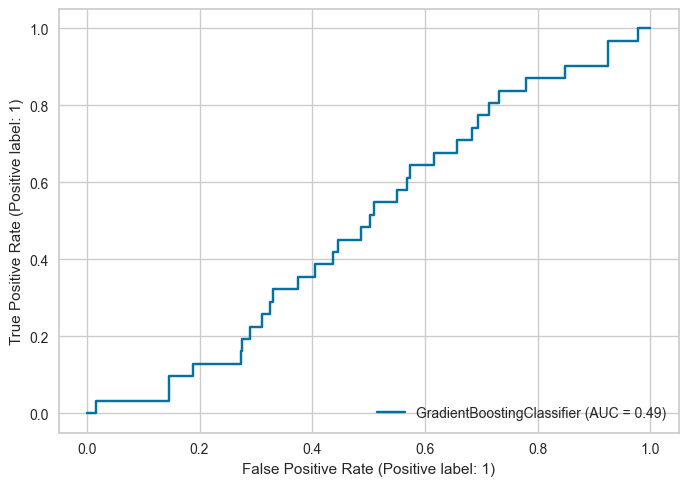

'Run time: 31.834141492843628, F1-score: 0.8832271762208068, MCC: -0.026666802373914476'

In [61]:
evaluate(X_train_svd, X_test_svd, y_train_balanced, y_test, GradientBoostingClassifier())

Similar to the PCA, this results are not satisfying 

### Feature selection 

We used two dimension reduction techniques, which compressed the many features we have into components, which we use for modeling. This did not yield great results.

We could gauge, which component is the best feature in our model, but a component is composed of several features (and not in a straight forward manner). If our goal is to know, which are the best features so we can exclude the rest, the dimension reduction via PCA or SVD are not appropriate. What we need to do is to reduced the dimension directly by selecting only the best features or by features selection.

#### Manual feature selection

The approach here will be to manually apply three principles basically and the approach is inspired by [Matt Namvarpour's Notebook](https://www.kaggle.com/code/halflingwizard/feature-selection-from-600-to-17-features) on the Semi-conductor's dataset. These include:
1. Exclude features with zero or close to zero variance
2. Exclude features with high pairwise correlation
3. Exclude features with a low correlation with our target   

##### Remove low variance features

For the removal of features with low variance we will used the `VarianceThreshold` from `sklearn`

In [62]:
selector = VarianceThreshold()
selector.fit(X_train_scaled)

VarianceThreshold()

In [63]:
mask = selector.get_support()
columns = X_train.columns
selected_cols = columns[mask]
n_features = len(selected_cols)
print(f'remaining features: {n_features}')

remaining features: 414


In [64]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = columns)
X_train_scaled_df = X_train_scaled_df[selected_cols]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = columns)
X_test_scaled_df = X_test_scaled_df[selected_cols]
X_train_scaled_df.shape

(2046, 414)

##### Remove high pairwise variance

Let us define a helpful function to remove highly correlated features. Here I will be applying a general rule of thumb that correlation of 0.5 between features is undesirable.

In [65]:
def correlation(dataset, threshold):
    '''Get list of pairwise correlated features that surpass a given threshold'''
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [66]:
corr_features = correlation(X_train_scaled_df, 0.5)
X_train_corr = X_train_scaled_df.drop(corr_features, axis=1)
X_test_corr = X_test_scaled_df.drop(corr_features, axis=1)
n_features3 = X_train_corr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 239 features, there are 175 features left.


#### Remove features that are weakly correlated with the target

In [67]:
def corrwith_target(dataframe, target, threshold):
    '''Get list of features correlated with the target that are below a given threshold'''
    cor = dataframe.corr()
    #Correlation with output variable
    cor_target = abs(cor[target])
    #Selecting non correlated features
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

In [68]:
# in order to find the correlation with target, I have to add target as a column to X_train_corr
dummy_train = X_train_corr.copy()
dummy_train['target'] = y_train

Here there is no general rule for what is a poorly correlated feature. After several trials I decided on a threshold of 0.025 correlation. 

In [69]:
corrwith_cols = corrwith_target(dummy_train, 'target', 0.025)
X_train_corw = X_train_corr.drop(corrwith_cols, axis=1)
X_test_corw = X_test_corr.drop(corrwith_cols, axis=1)
n_features4 = X_train_corw.shape[1]
print(f'After removing {len(corrwith_cols)} features, there are {n_features4} features left.')

After removing 112 features, there are 63 features left.


Well this is a significant drop from 530 features to 56. Lets see if the remaining 56 features are sufficient for predicting the target.

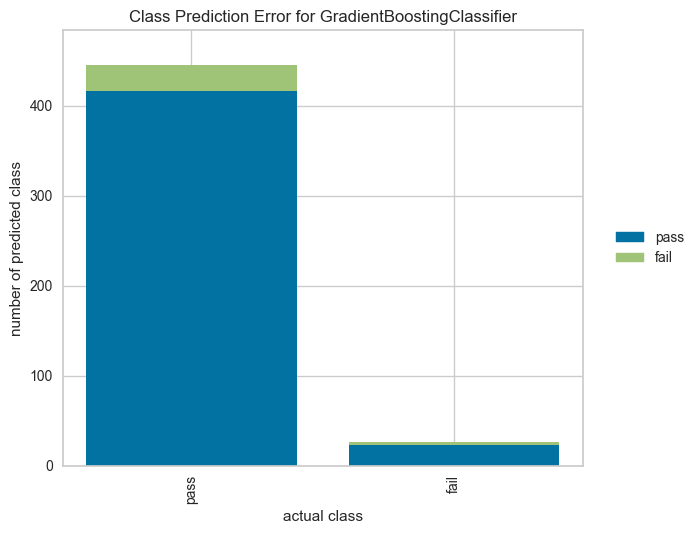

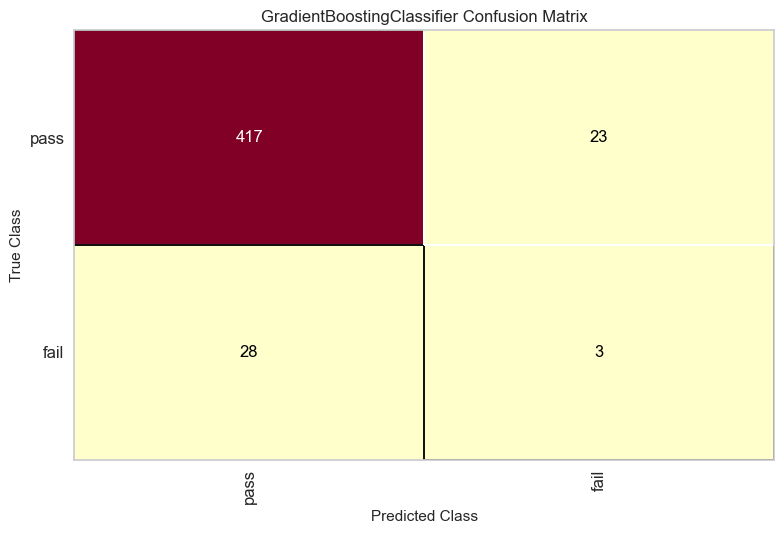

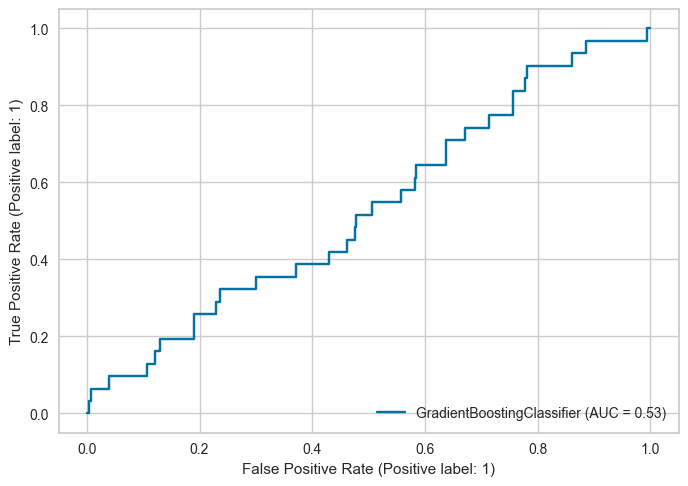

'Run time: 13.169100999832153, F1-score: 0.89171974522293, MCC: 0.04831865385363011'

In [70]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, GradientBoostingClassifier())

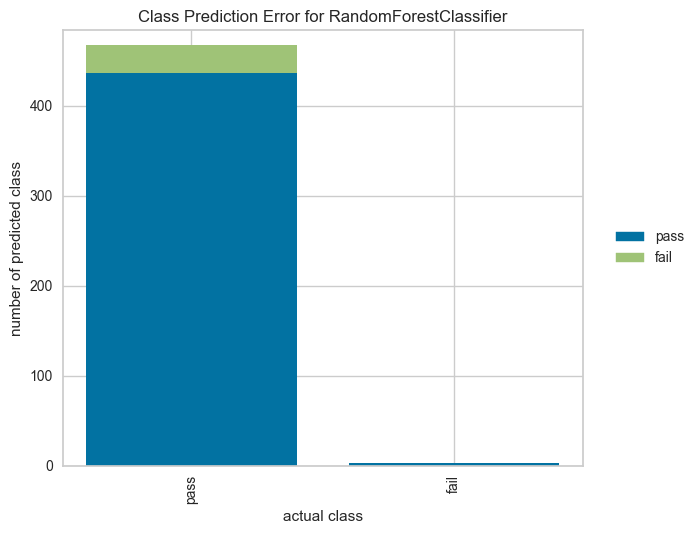

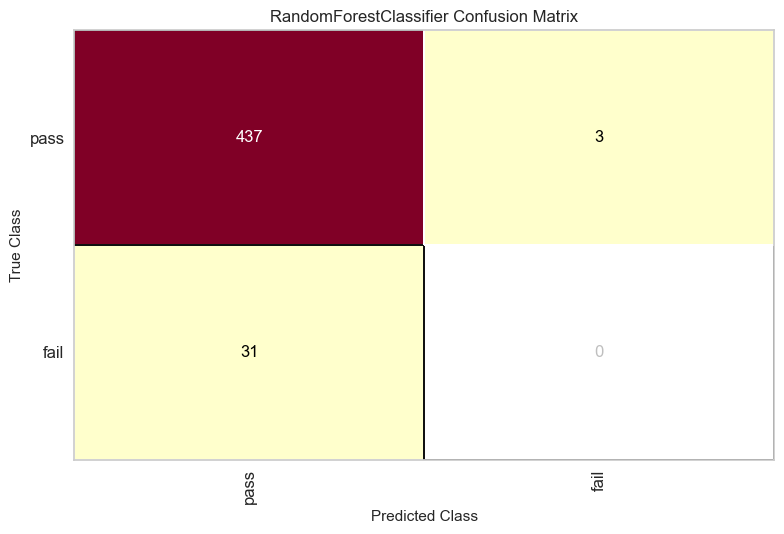

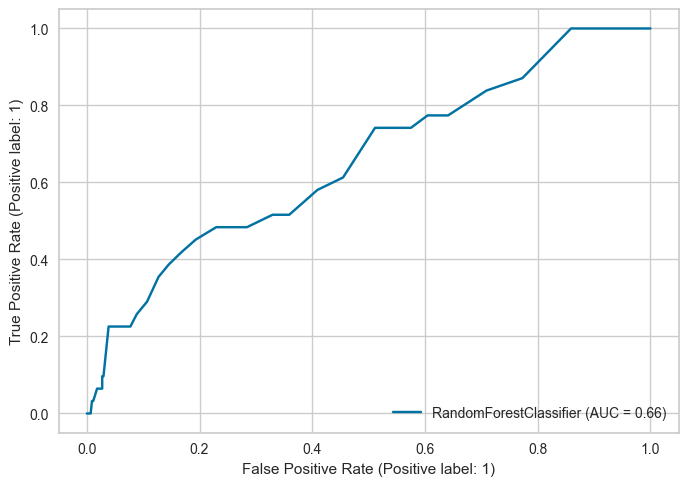

'Run time: 4.840107202529907, F1-score: 0.9278131634819533, MCC: -0.02125162821130893'

In [71]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, RandomForestClassifier())

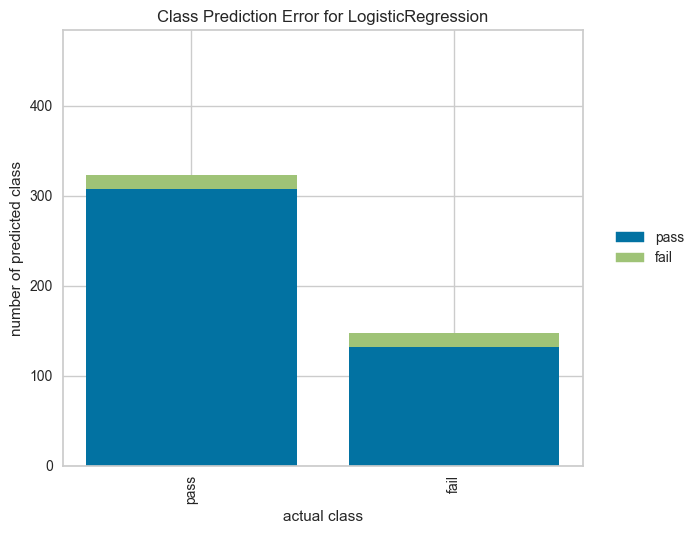

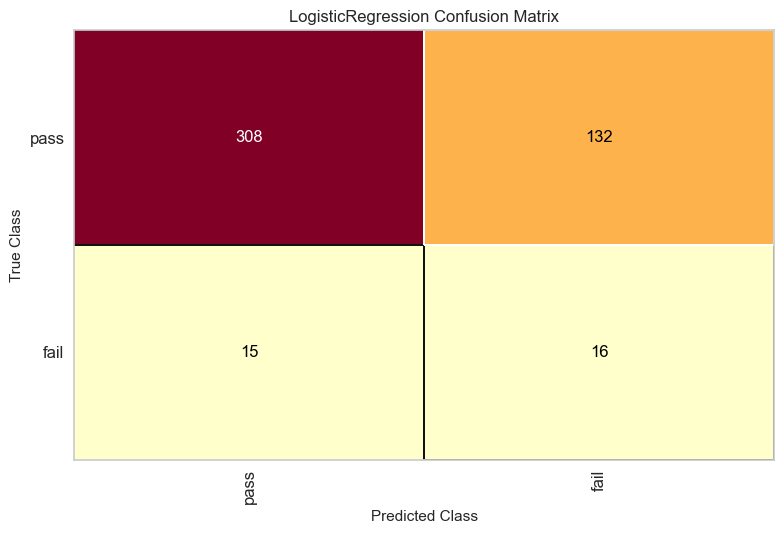

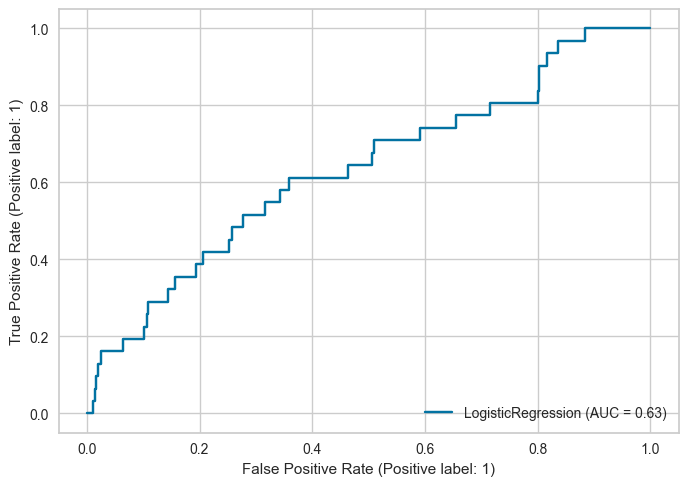

'Run time: 0.033826589584350586, F1-score: 0.6878980891719745, MCC: 0.11544846825405179'

In [72]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, LogisticRegression())

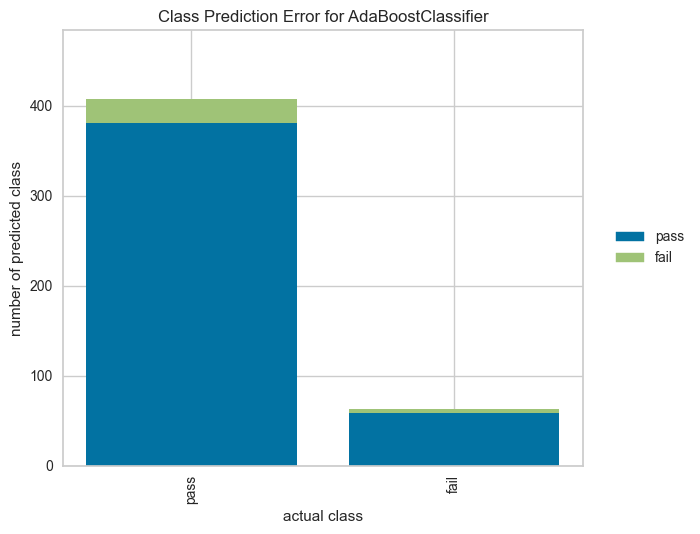

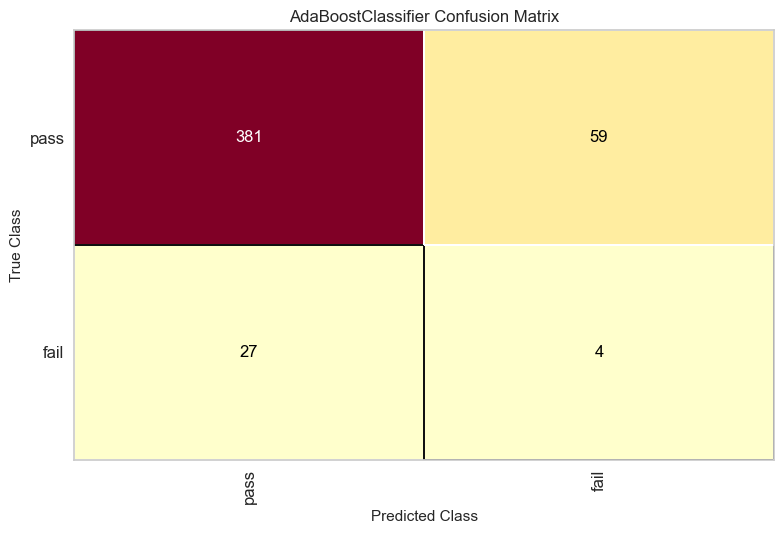

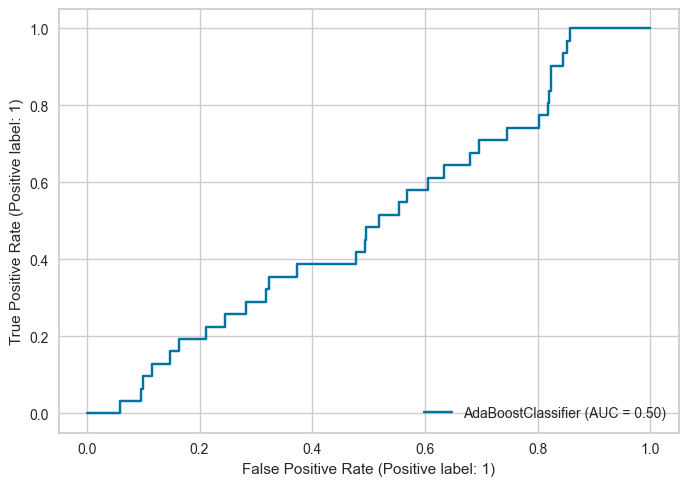

'Run time: 2.444331645965576, F1-score: 0.8174097664543525, MCC: -0.0036850344248468073'

In [73]:
evaluate(X_train_corw, X_test_corw, y_train_balanced, y_test, AdaBoostClassifier())

Here the Logistic regression does give adequate results, while the other models fall short.

#### LASSO Regularization feature selection 

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e., to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each predictor. From the different types of regularization, Lasso or L1 has the property that can shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [74]:
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=7).fit(X_train_balanced, y_train_balanced)
model = SelectFromModel(logistic, prefit=True, )

X_train_new = model.fit_transform(X_train_balanced)
columns_lasso = model.get_feature_names_out()
X_train_lasso = pd.DataFrame(X_train_new, columns=columns_lasso)
X_test_lasso = pd.DataFrame(X_test, columns=columns_lasso)


In [75]:
X_train_lasso.shape

(2046, 189)

We see that LASSO reduced the features from 530 to 195. Lets test them out with the three models.

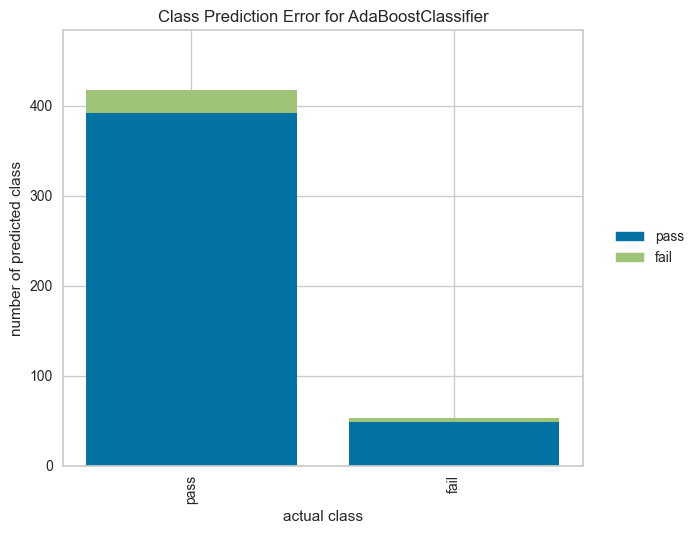

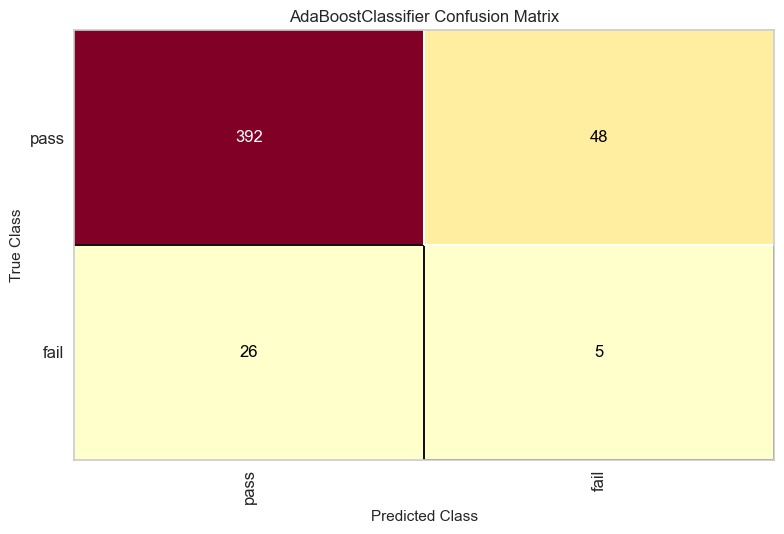

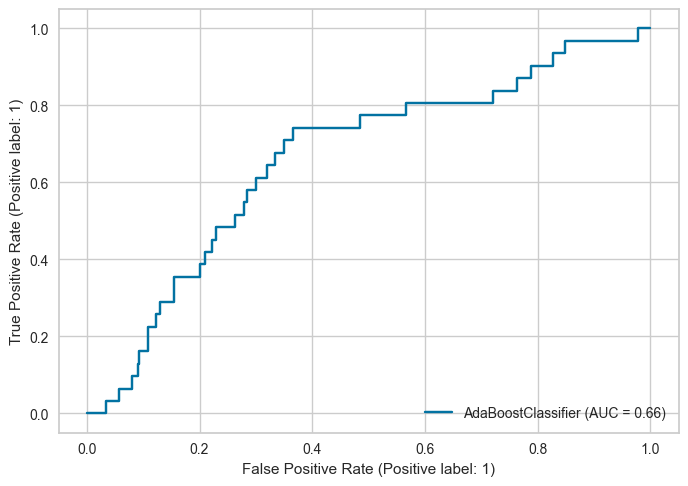

'Run time: 7.980522632598877, F1-score: 0.8428874734607219, MCC: 0.040958753644079283'

In [76]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, AdaBoostClassifier())

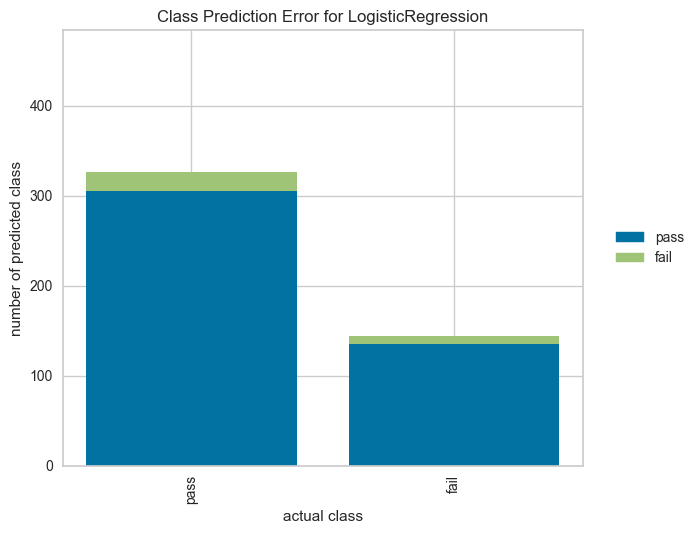

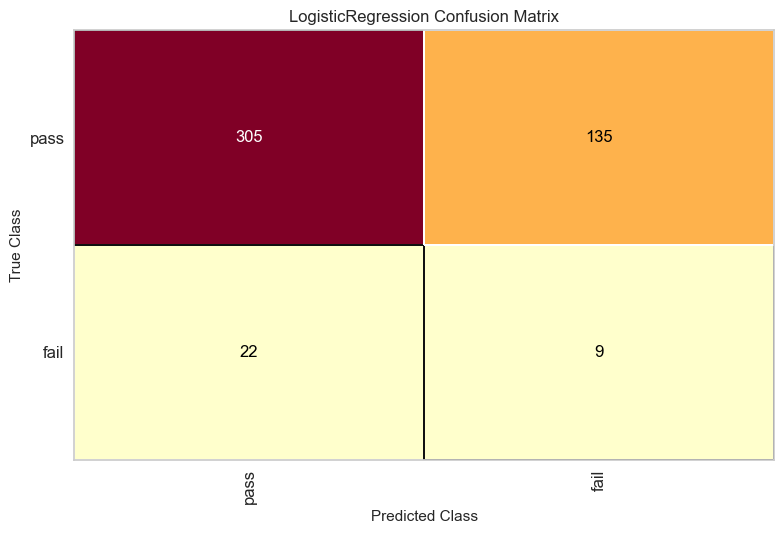

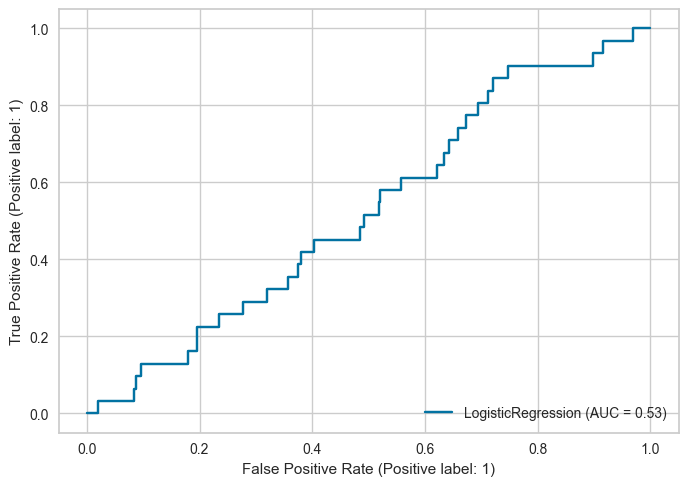

'Run time: 0.30019164085388184, F1-score: 0.6666666666666666, MCC: -0.008878103640950782'

In [77]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, LogisticRegression())

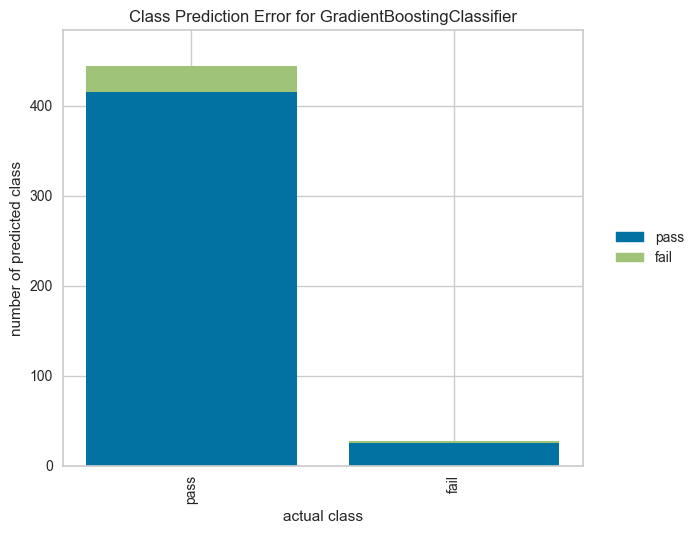

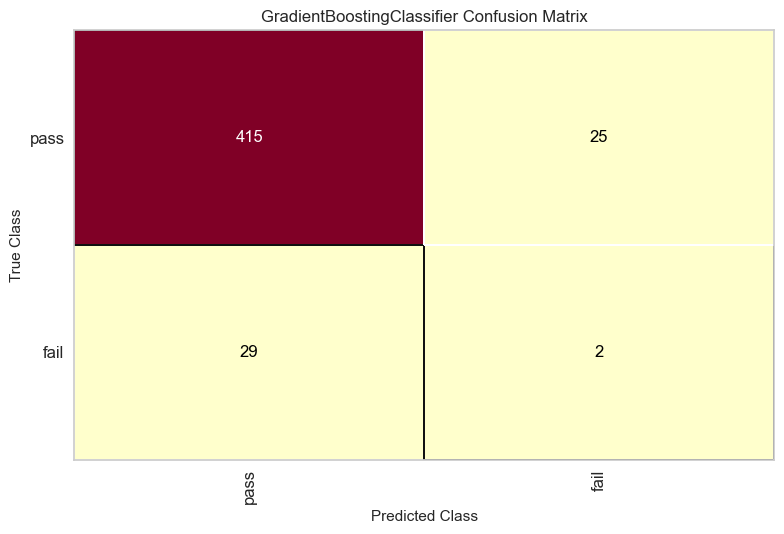

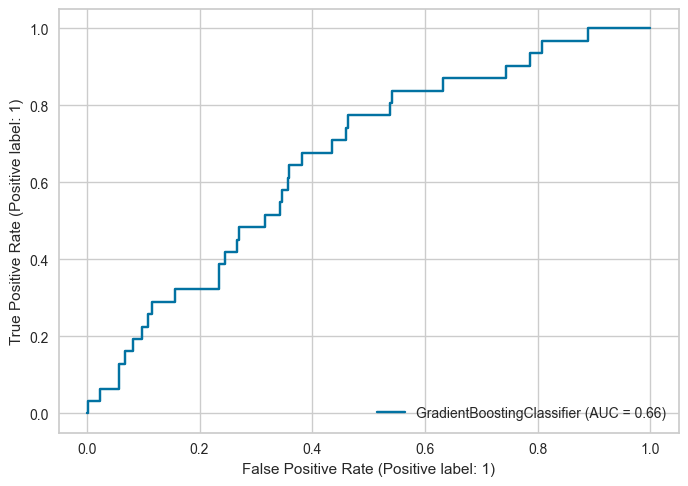

'Run time: 43.68355202674866, F1-score: 0.8853503184713376, MCC: 0.008211240015110562'

In [78]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, GradientBoostingClassifier())

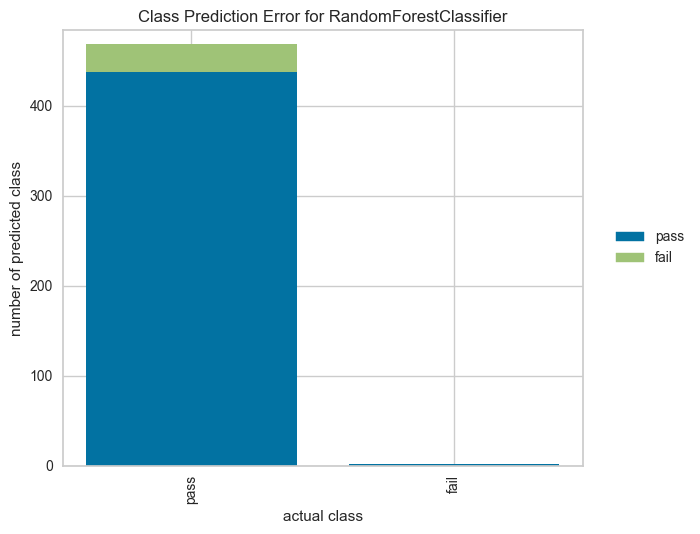

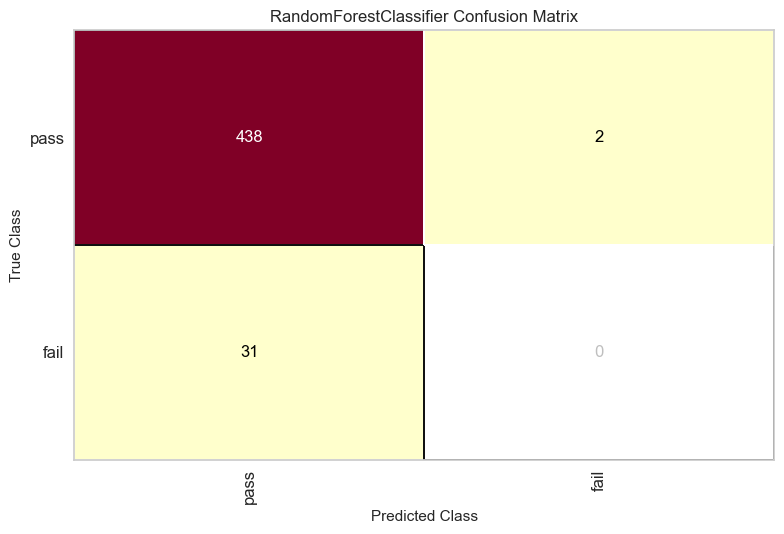

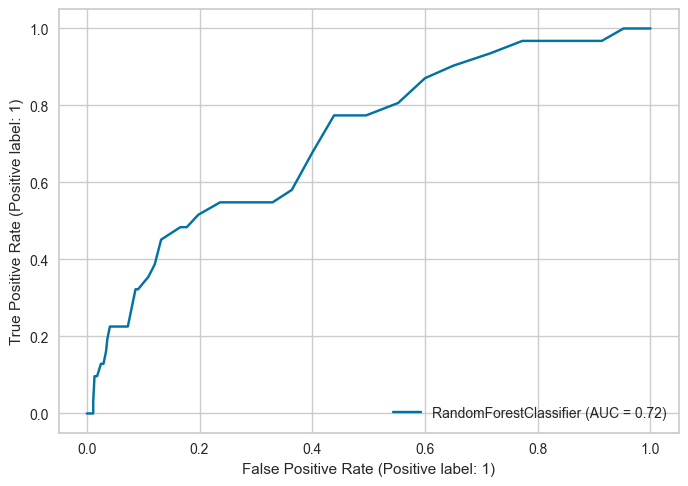

'Run time: 8.675913333892822, F1-score: 0.9299363057324841, MCC: -0.017333373094521518'

In [79]:
evaluate(X_train_lasso, X_test_lasso, y_train_balanced, y_test, RandomForestClassifier())

These results are not impressive. So far the best technique for reducing the data seems to be the manual filtering of features based on their variance, inner correlation and correlation with the target.

##### Random Forest Importance

Random Forest can also be used a tool for feature selection, as the model has an attribute `feature_importance_`, which by default is based on the Gini impurity. Let us see which are the most important features according to this method.

In [129]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train_balanced, y_train_balanced)

importance = model.feature_importances_

importance_df = pd.DataFrame({"Features" : X_train.columns,
                              "Importance" : importance})

importance_df = importance_df.sort_values('Importance')


<Axes: >

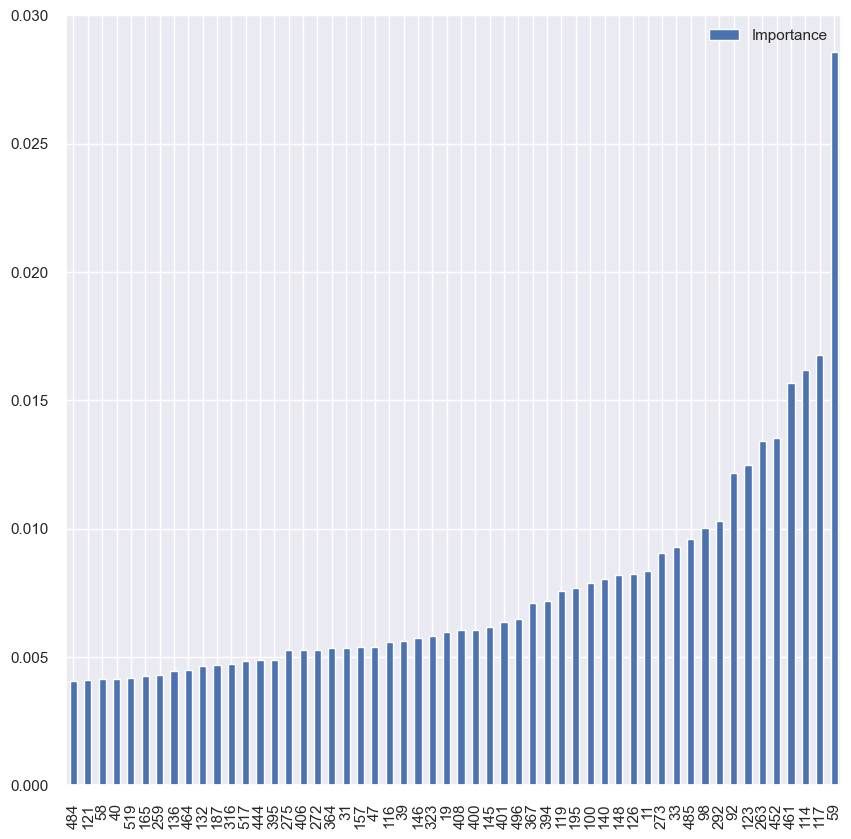

In [203]:
importance_df_filtered_1 = importance_df[importance_df['Importance']>0.00405]
importance_df_filtered_1.plot.bar(figsize = (10,10))

In [204]:
importance_df_filtered_1.shape

(54, 2)

<Axes: >

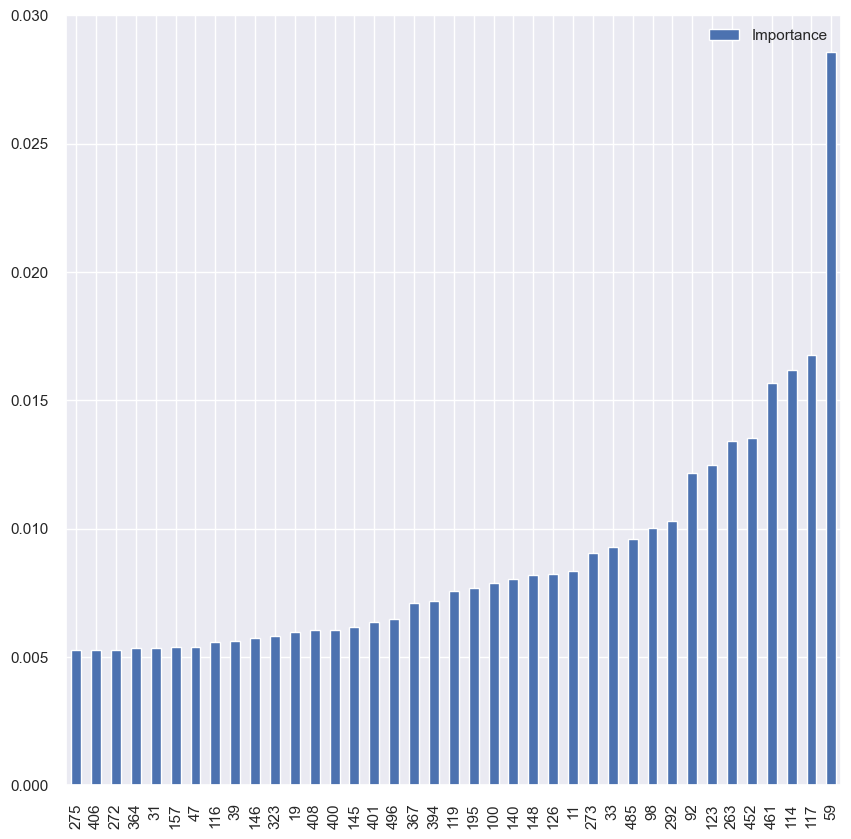

In [205]:
importance_df_filtered_2 = importance_df[importance_df['Importance']>0.005]
importance_df_filtered_2.plot.bar(figsize = (10,10))

In [206]:
importance_df_filtered_2.shape

(39, 2)

Initially the graph was hard to make out because it included all of the features but after applying a filter of > 0.04 importance we get 55 features and with > 0.05 we get 39. I am pretty sure that the RF will be our final model, but for the sake of consistency let us test out the 54 and 35 feature dataset on all try models. 

In [207]:
X_train_rf1 = X_train_balanced[(importance_df_filtered_1['Features'])]
X_test_rf1 = X_test[(importance_df_filtered_1['Features'])]
X_train_rf1.shape

(2046, 54)

In [209]:
X_train_rf2 = X_train_balanced[(importance_df_filtered_2['Features'])]
X_test_rf2 = X_test[(importance_df_filtered_2['Features'])]
X_train_rf2.shape

(2046, 39)

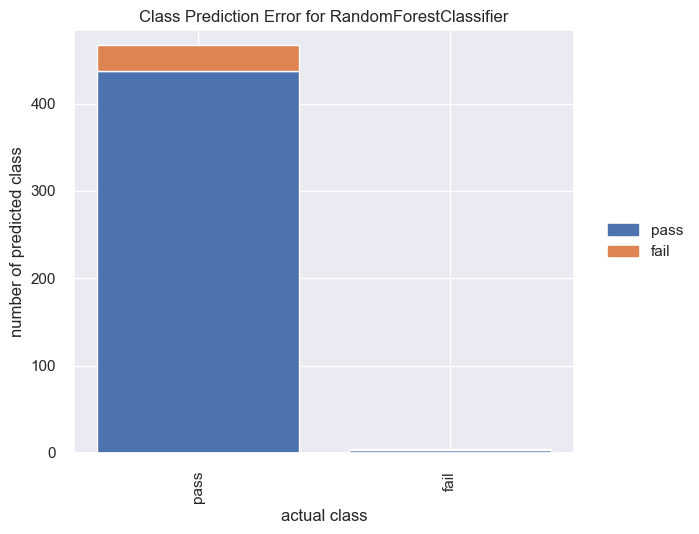

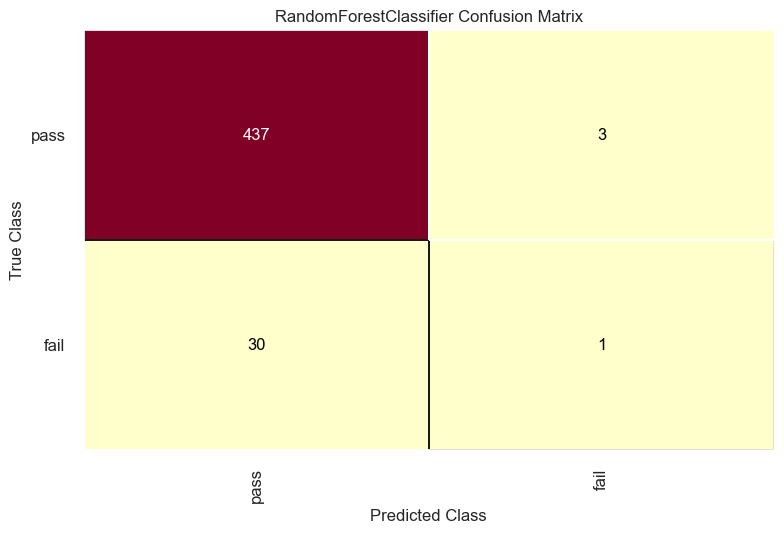

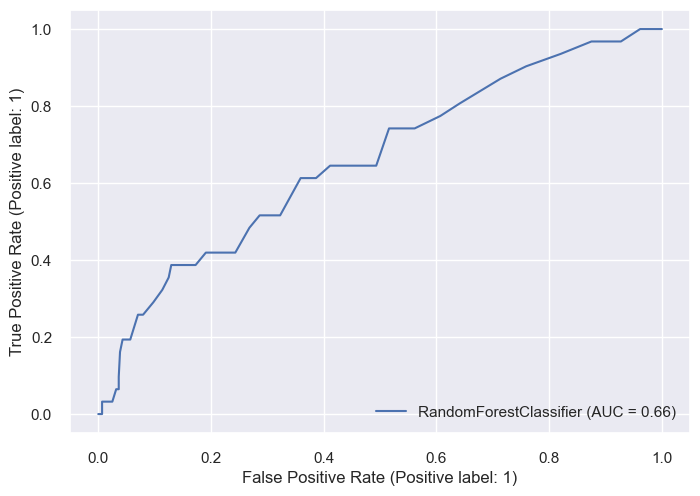

'Run time: 4.321461915969849, F1-score: 0.9299363057324841, MCC: 0.0687438504011854'

In [210]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, RandomForestClassifier())

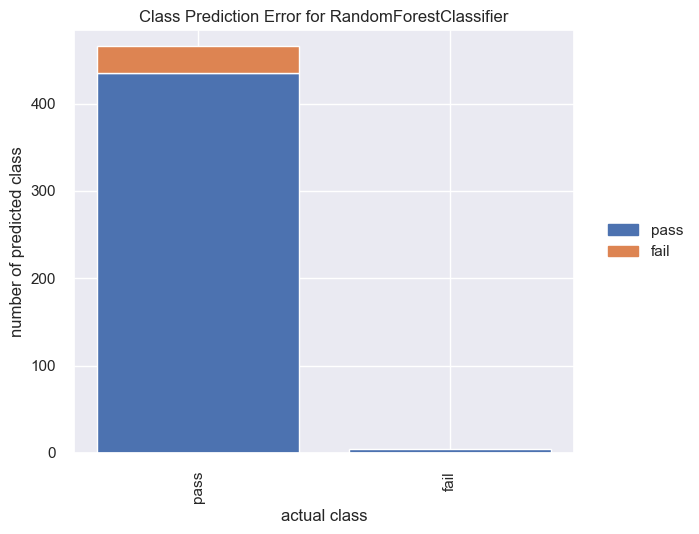

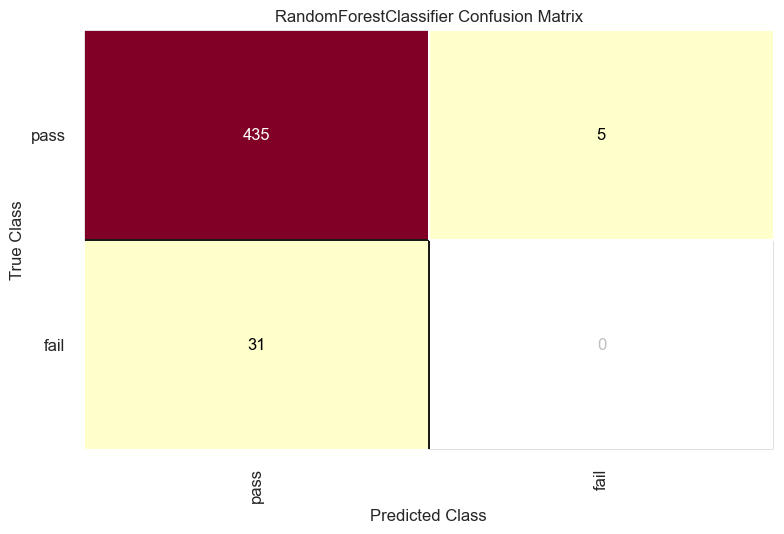

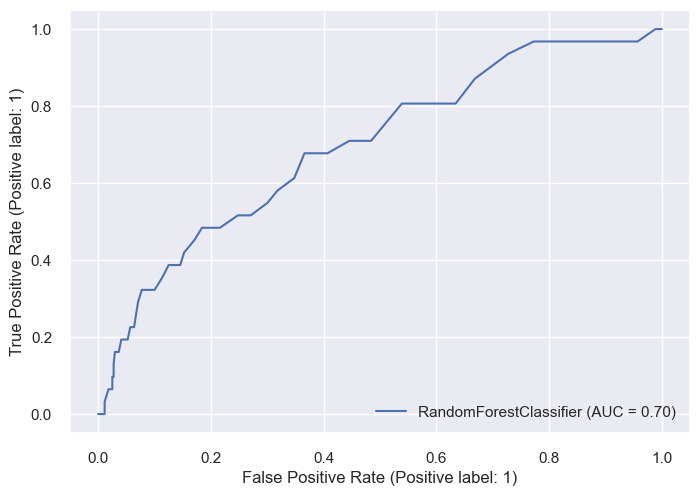

'Run time: 3.4872593879699707, F1-score: 0.9235668789808917, MCC: -0.027494545977796502'

In [212]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, RandomForestClassifier())

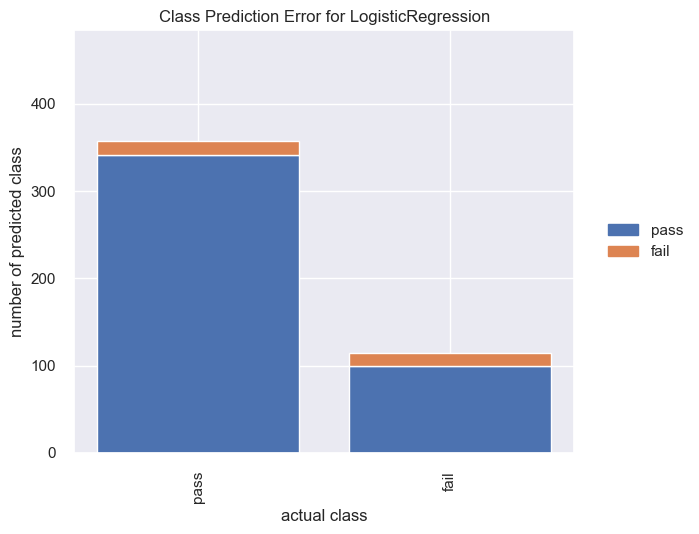

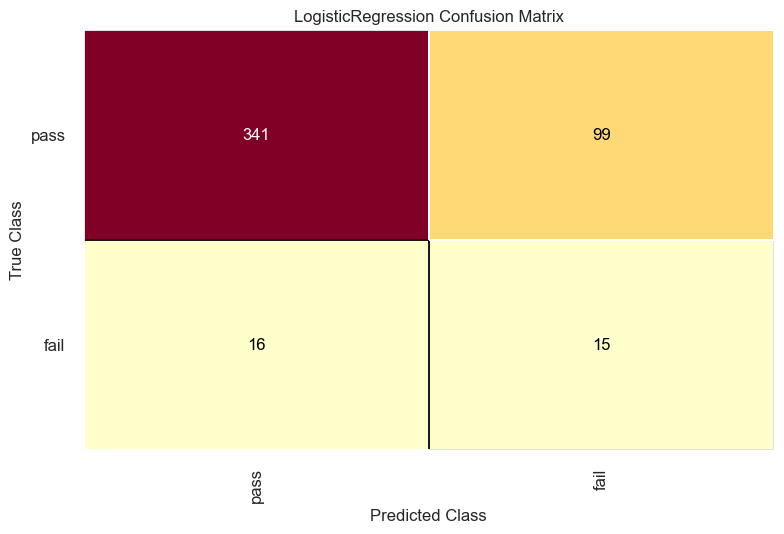

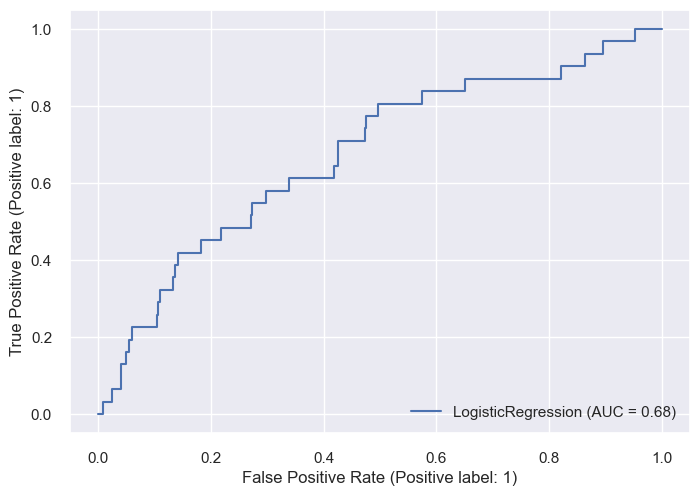

'Run time: 0.11516284942626953, F1-score: 0.7558386411889597, MCC: 0.14986630462121256'

In [213]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, LogisticRegression())

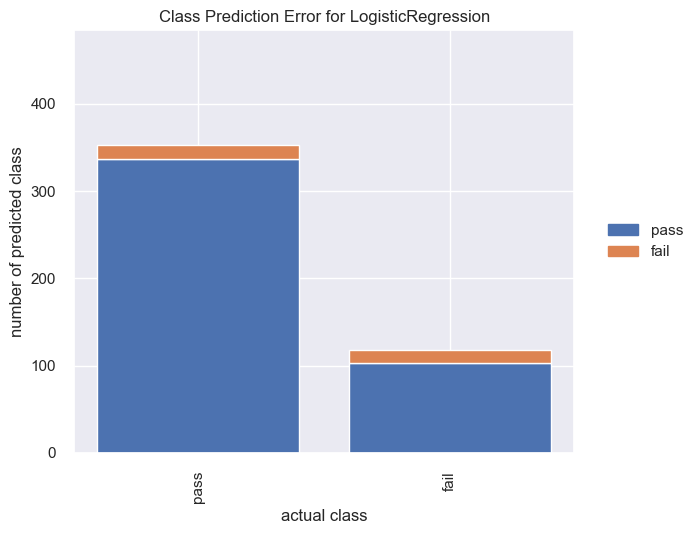

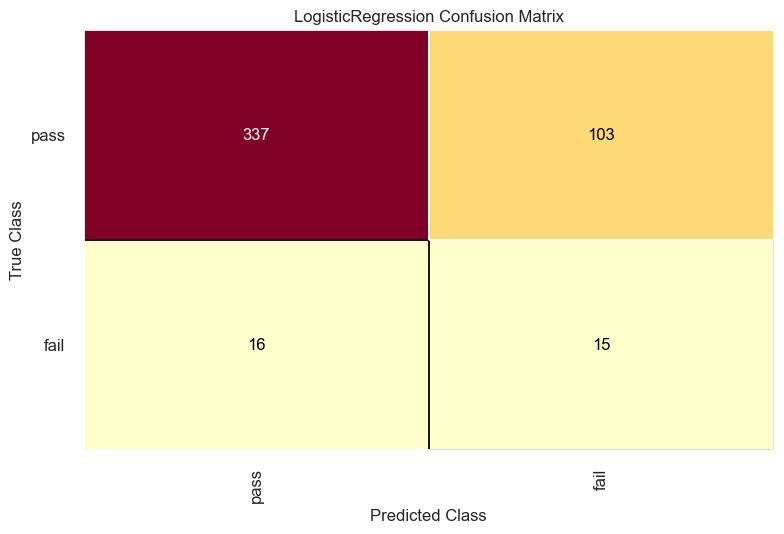

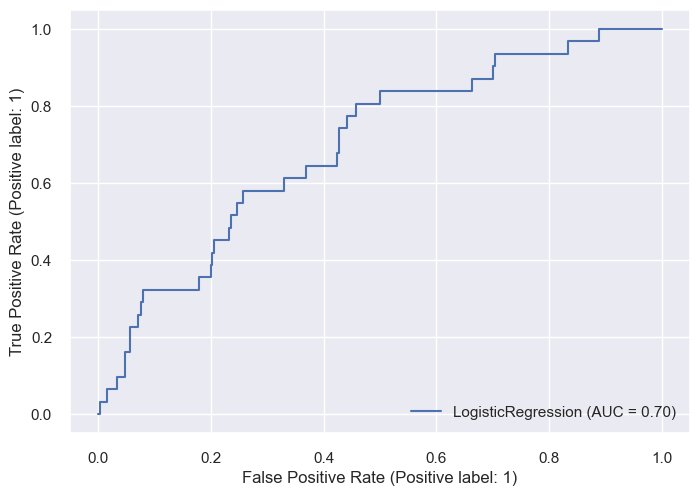

'Run time: 0.09182024002075195, F1-score: 0.7473460721868365, MCC: 0.1429343437549948'

In [214]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, LogisticRegression())

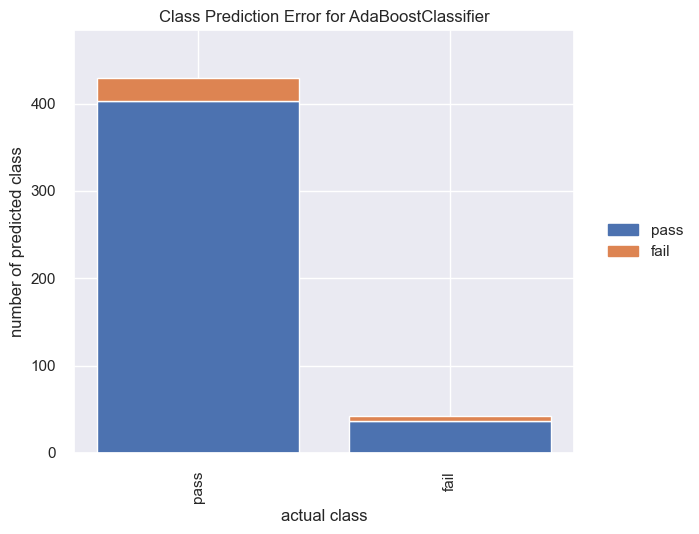

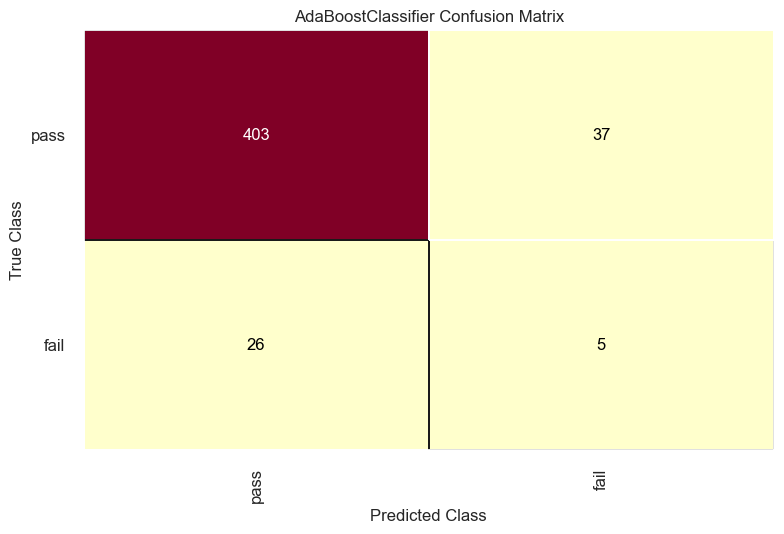

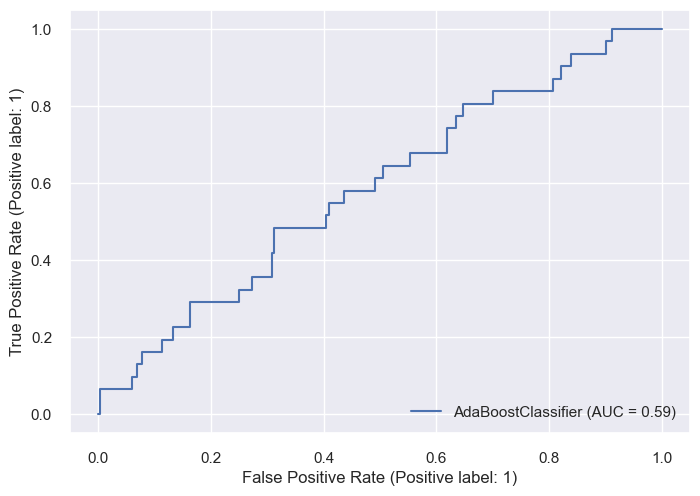

'Run time: 2.0702288150787354, F1-score: 0.8662420382165607, MCC: 0.06716884720697866'

In [215]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, AdaBoostClassifier())

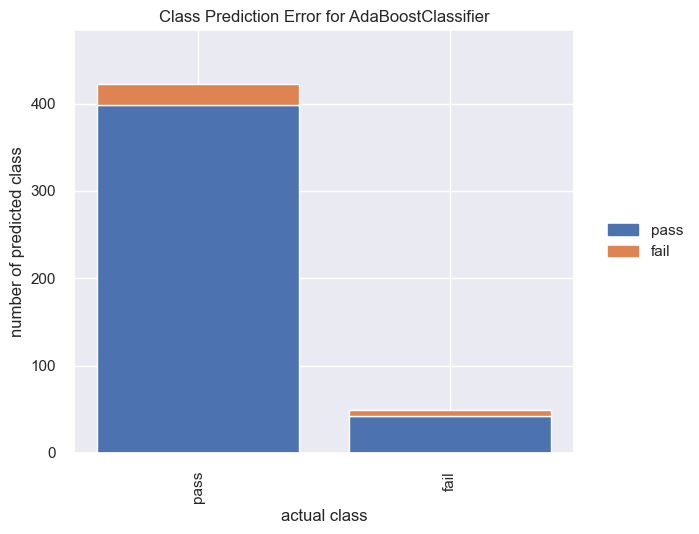

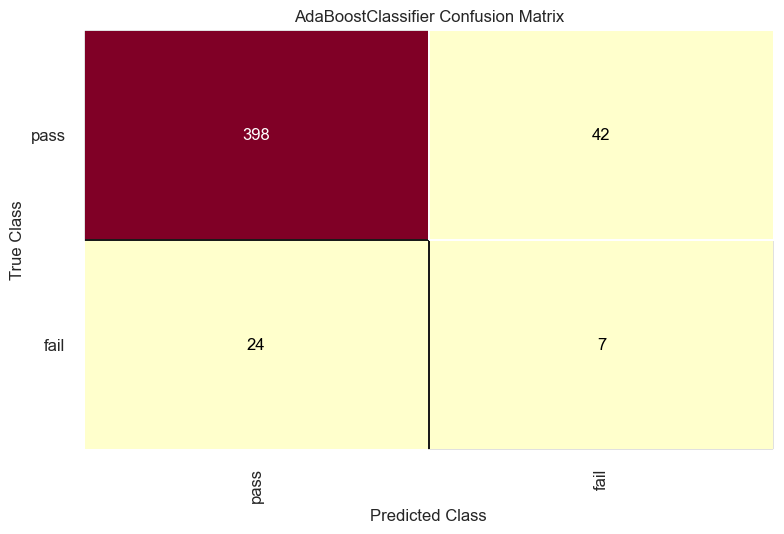

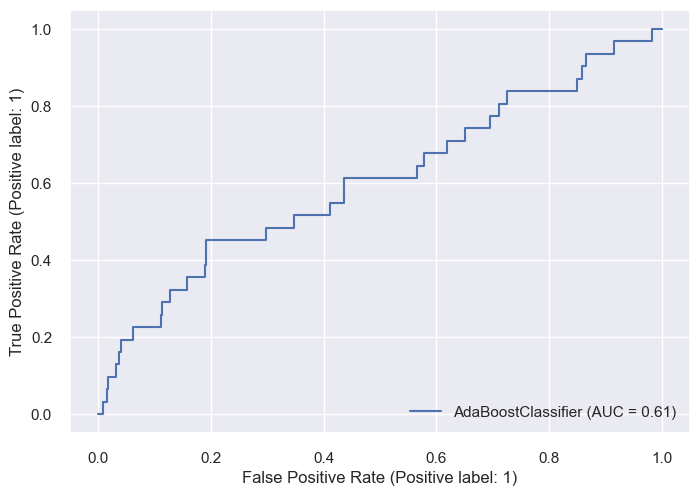

'Run time: 1.5796191692352295, F1-score: 0.8598726114649682, MCC: 0.10586936445674408'

In [216]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, AdaBoostClassifier())

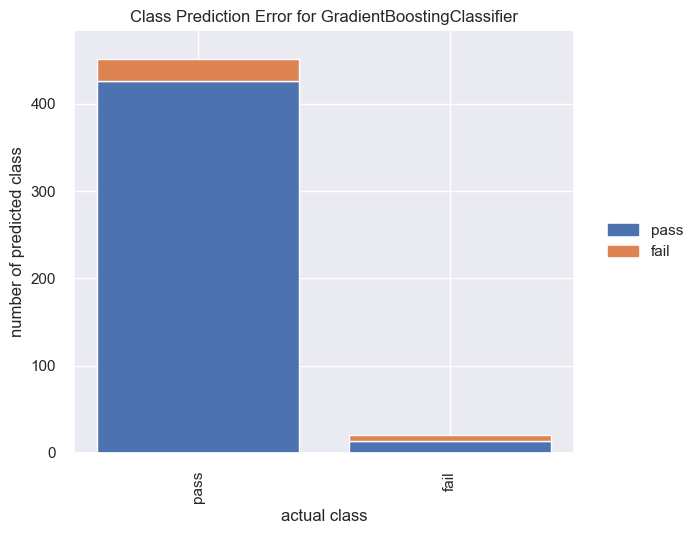

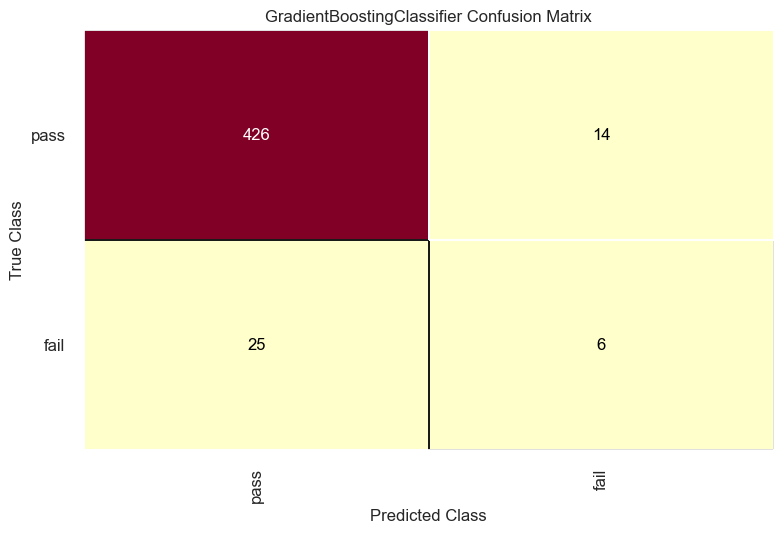

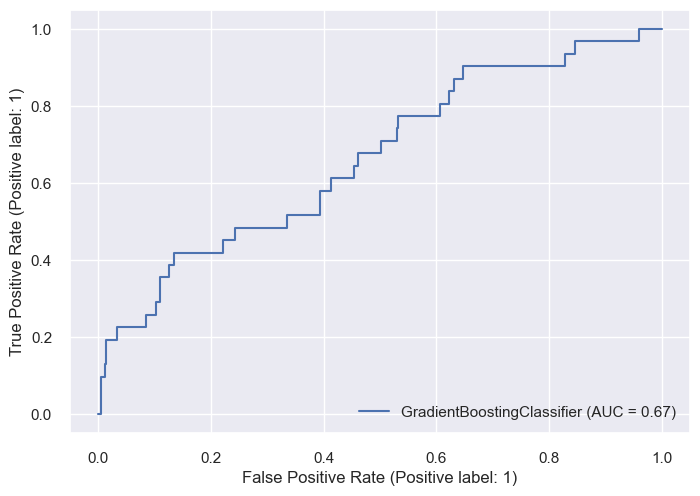

'Run time: 11.116539001464844, F1-score: 0.9171974522292994, MCC: 0.198881805601158'

In [217]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, GradientBoostingClassifier())

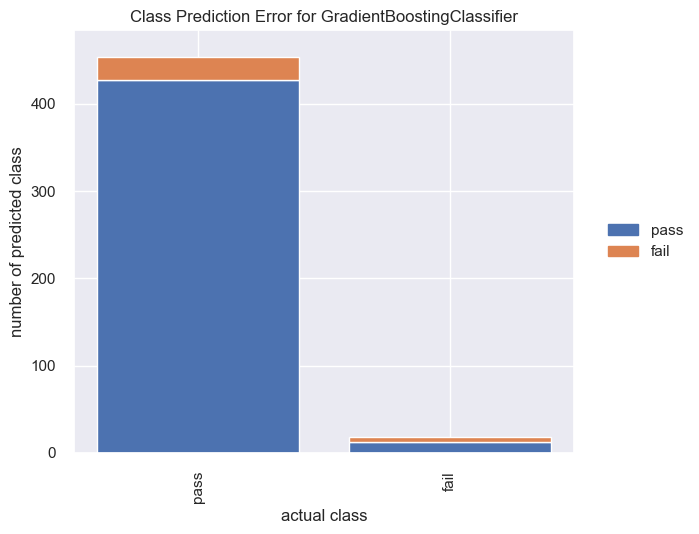

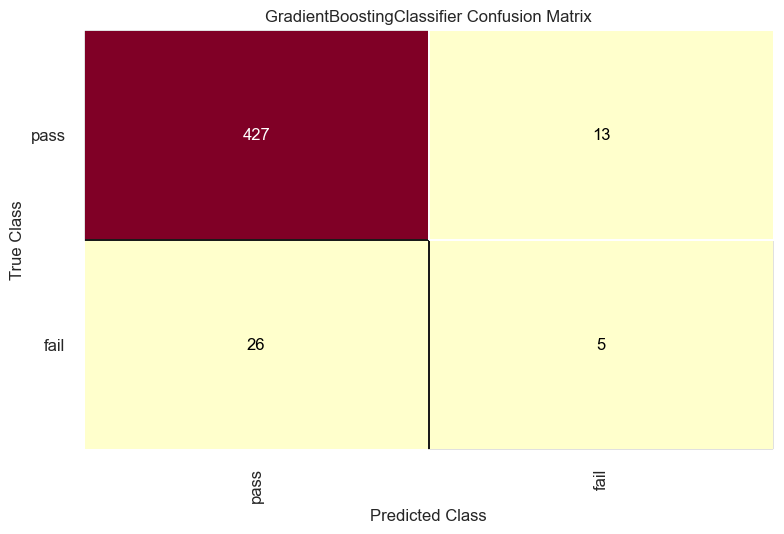

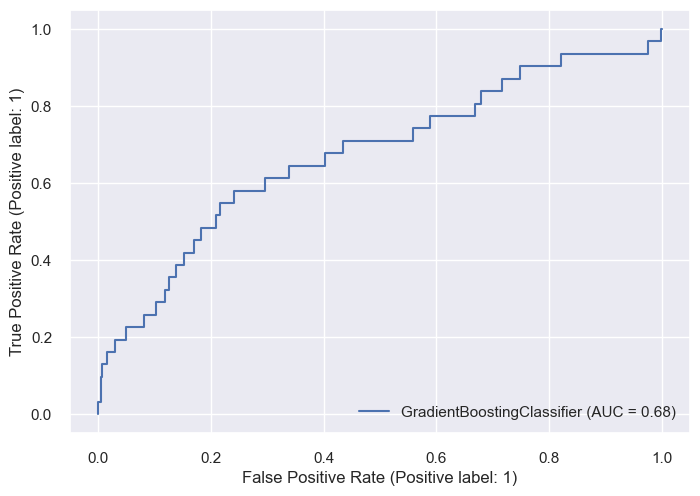

'Run time: 8.097837448120117, F1-score: 0.9171974522292994, MCC: 0.17039448662375511'

In [218]:
evaluate(X_train_rf2, X_test_rf2, y_train_balanced, y_test, GradientBoostingClassifier())

The `LogisticRegression` performed quite well on the 55 features dataset

Out of all the dimension reduction and feature selection methods and all the models applied the only significant results we get is when using the `LogisticRegression`, with the `RandomForestClassier` as a feature selection techniques. We tried several combinations of features and the `X_train_rf1` gave the best results, which is a 54 feature dataset. Let us see if we can improve the LogisticRegression any further.   


#### Model tuning

##### Class weights
We can actually tell our model if the prediction of the classes in our problem are balanced or not. Let us assume that in our cases the prediction of failed tests (Target = 1) is more important then the prediction of passes (Target = 0).

After several trials I find that a 1:2 ration in `class_weight` works best for the `LogisticRegression`

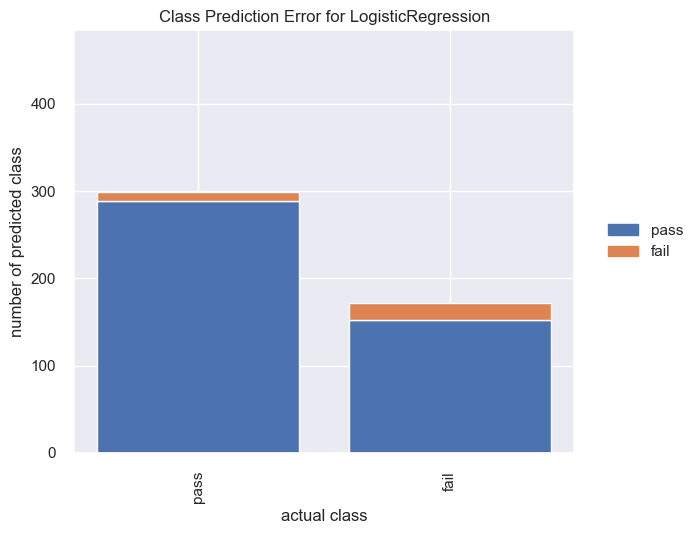

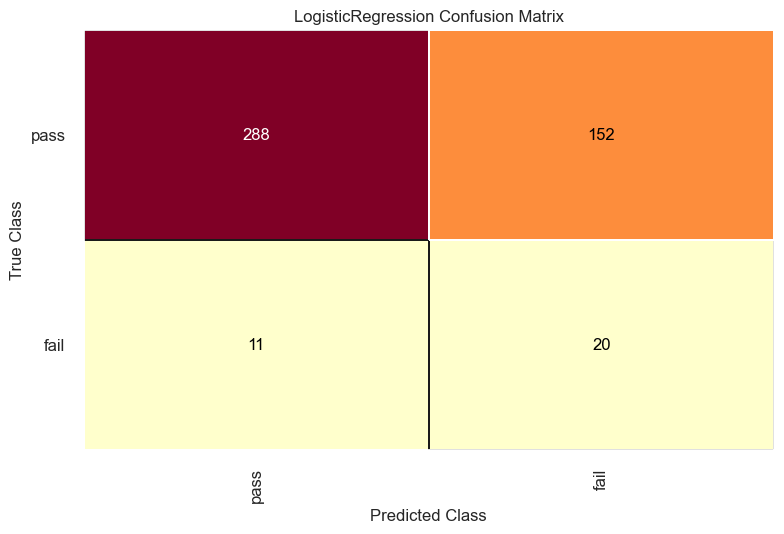

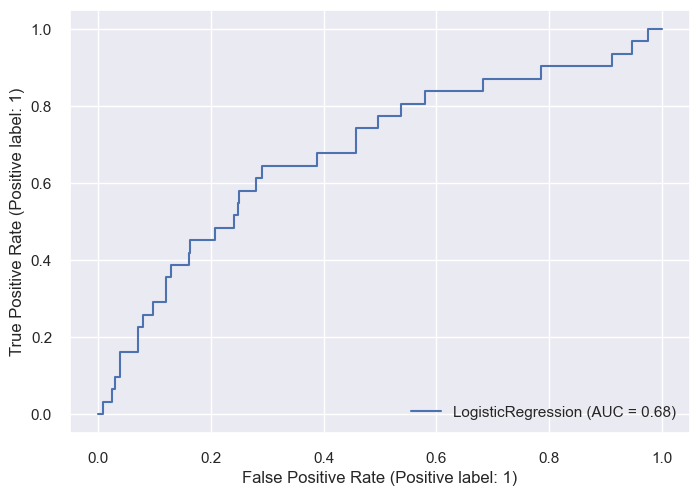

'Run time: 0.08379697799682617, F1-score: 0.6539278131634819, MCC: 0.1543490228312578'

In [219]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, LogisticRegression(class_weight={0:1, 1:2}))

Now we are able to predict 70% of the fails in the test dataset, but this comes with the price of reducing the prediction of passes. We have 149 false negatives (false we predict these data points as fails).

##### Random forest hyperparameters

We may do the same for the `RandomForestClassifier`. Note that even very with high weights for the fails it is hard for the Random forest to predict the failures, while it excels at predicting the passes.

After many trails I chose several hyperparameters for the `RandomForestClassifier`, that give better predictions for the fails. Normally I would use a `GridSearchCV` for this but since I am most interested in the confusion matrix I did the hyperparameter tuning manually. 

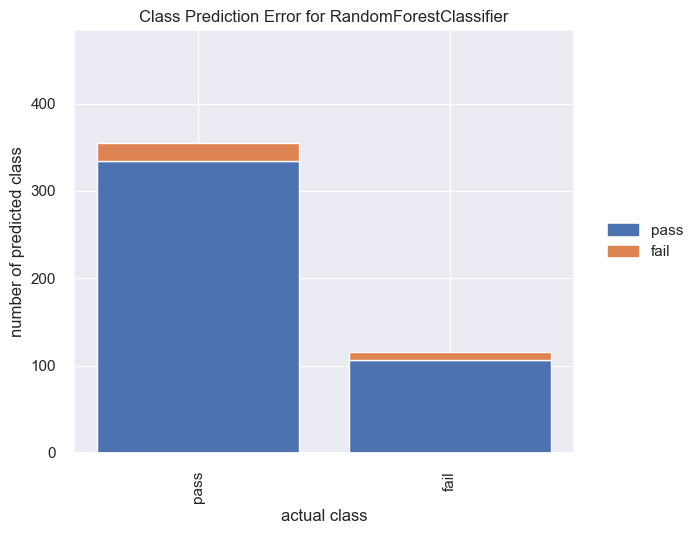

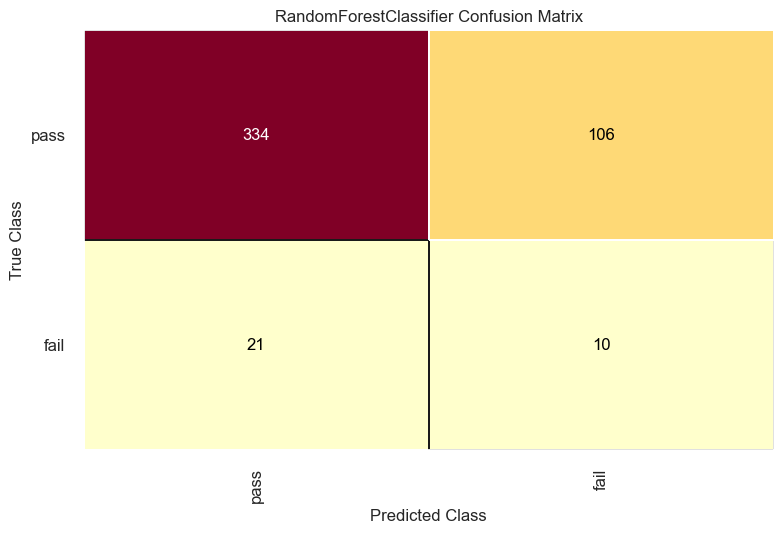

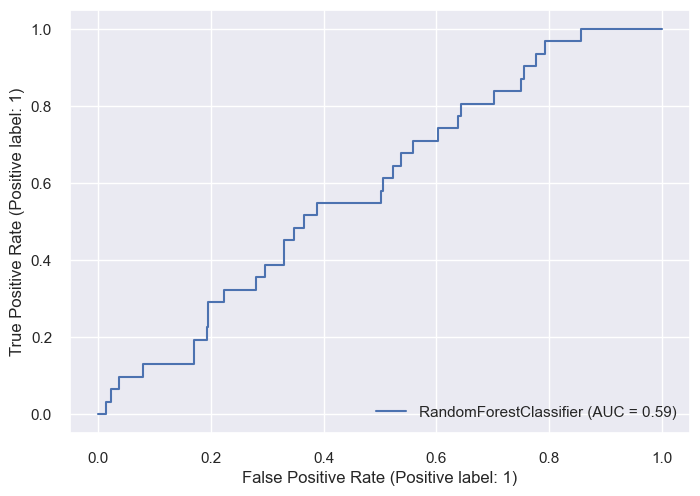

'Run time: 4.256454944610596, F1-score: 0.7303609341825902, MCC: 0.047004001833534655'

In [221]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         RandomForestClassifier(class_weight={0:1, 1:15}, random_state=12, 
                                n_estimators=100, min_samples_leaf = 10, max_depth=16))

With this small forest of 20 trees we are able to predict 38% of the fails and 75% of the passes. This a big improvement since initially the RF predicted no fails at all.  

GBM hyperparameters

Boosting algorithms do not have the `class_weight` option since the algorithm itself deals well with imbalanced data. Again after manual tests I chose the following hyperparameters. Note I am using a `max_dept` = 1, so the GBM has only stump trees. 

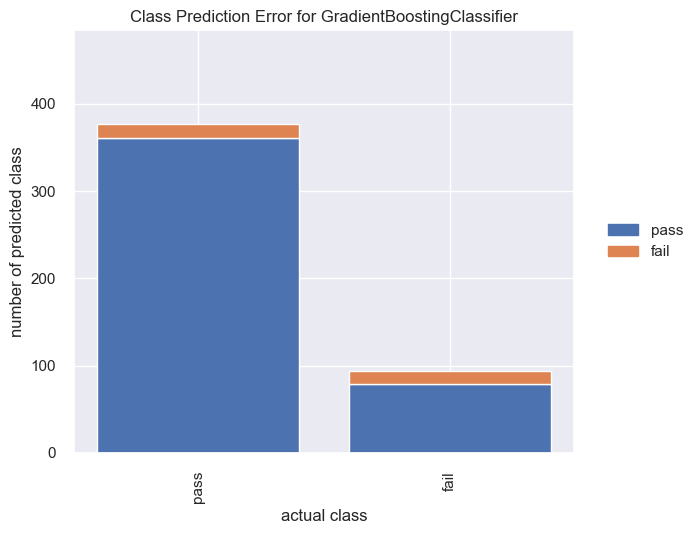

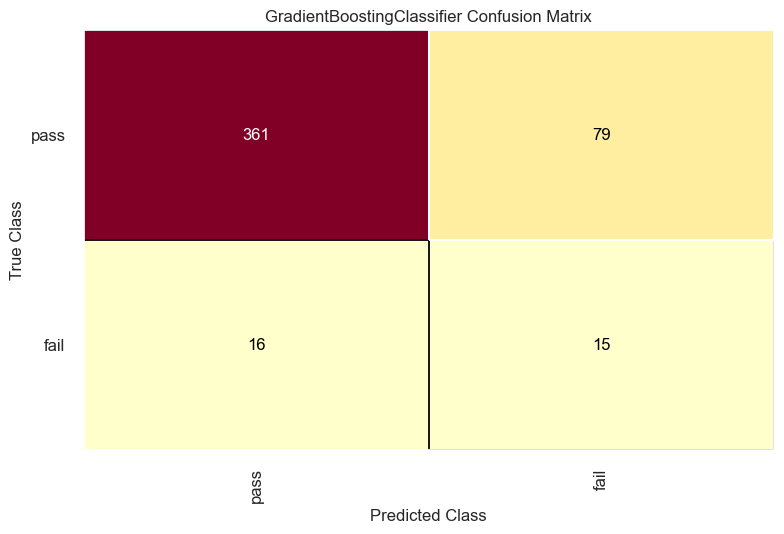

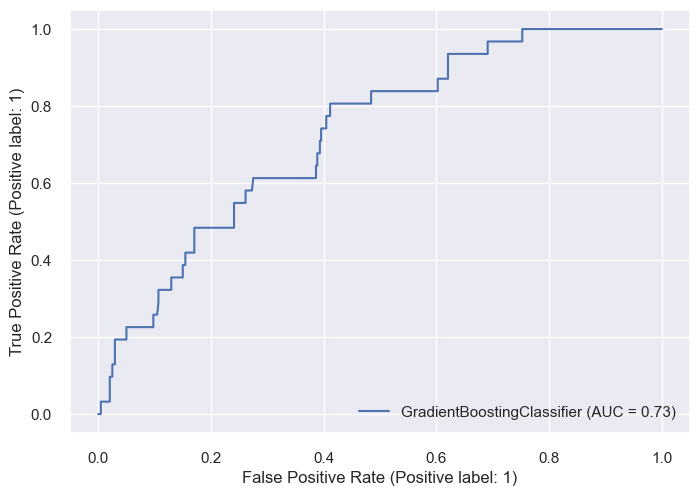

'Run time: 18.13241934776306, F1-score: 0.7983014861995754, MCC: 0.1888038936183771'

In [222]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         GradientBoostingClassifier(random_state=12, n_estimators=500, learning_rate=0.004, 
                                    min_samples_leaf = 10, max_depth=1))

The GBM is able to predict 48% of the fails and 82% of the passes, by which it exceeds the RF

##### AdaBoost hyperparameters

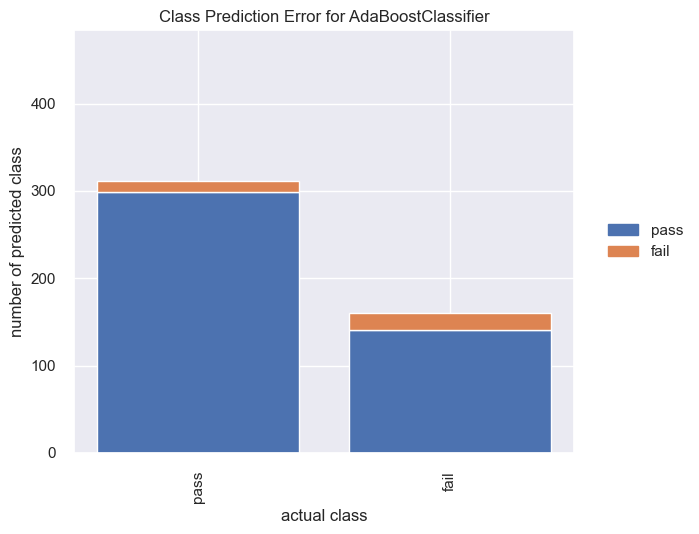

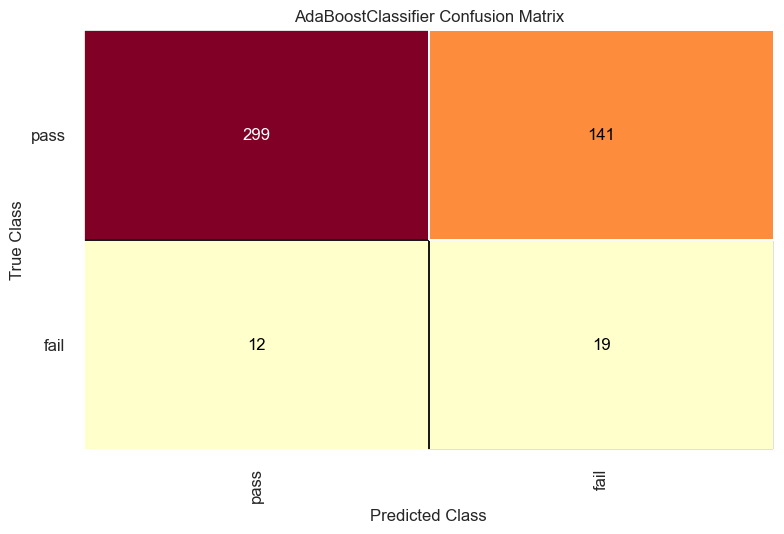

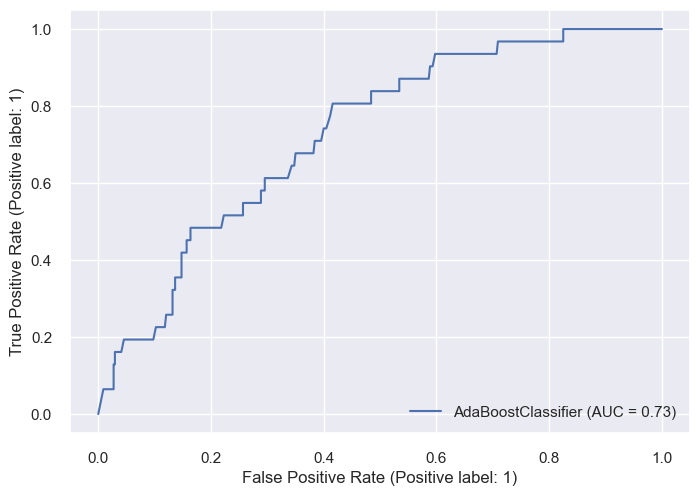

'Run time: 41.773807525634766, F1-score: 0.6751592356687898, MCC: 0.15311462156729516'

In [223]:
evaluate(X_train_rf1, X_test_rf1, y_train_balanced, y_test, 
         AdaBoostClassifier(random_state=12, n_estimators=1000, learning_rate=0.003, algorithm = 'SAMME'))

The `AdaBoostClassifier` is somewhat similar to the `LogisticRegression`, it predicts well the fails but at the expense of lower success in predicting the passes.

#### Ensemble method

Let as make an ensemble model using the `VotingClassifier`, with all 4 model types

In [224]:
clf1 = LogisticRegression(class_weight={0:1, 1:2})
clf2 =  RandomForestClassifier(class_weight={0:1, 1:15}, random_state=12, 
                                n_estimators=20, min_samples_leaf = 10, max_depth=16)
clf3 = GradientBoostingClassifier(random_state=12, n_estimators=500, learning_rate=0.004, 
                                    min_samples_leaf = 10, max_depth=1)
clf4 =  AdaBoostClassifier(random_state=12, n_estimators=1000, learning_rate=0.003, algorithm = 'SAMME')

In [225]:
def evaluate2(train_df, test_df, train_target, test_target, estimator):
    
    # first, we should scale our data so logistic regression works better
    
    # training the model
    start_time = time.time()
    method = SMOTE()
    train_df, train_target = method.fit_resample(train_df, train_target)
    estimator.fit(train_df, train_target)
    runtime = time.time() - start_time
    
    # evaluation and scoring
    y_pred = estimator.predict(test_df)
    y_true = test_target
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(estimator, classes=['pass','fail'])
    cre.score(test_df, y_true)
    cre.show()
    cm = ConfusionMatrix(estimator, classes=['pass','fail'])
    cm.score(test_df, y_true)
    cm.show()
    
    return f'Run time: {runtime}, F1-score: {f1score}, MCC: {mccscore}' 

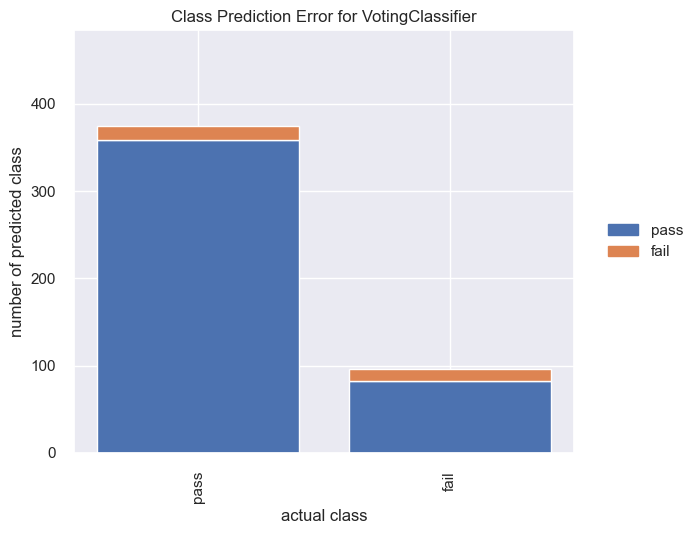

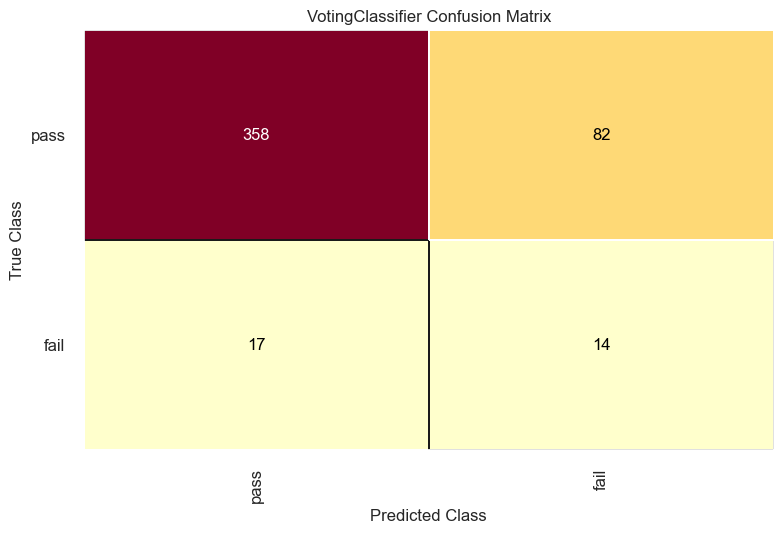

'Run time: 60.56929349899292, F1-score: 0.7898089171974523, MCC: 0.16327140386377553'

In [226]:
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gbm', clf3), ('ada', clf4)], voting='hard')
evaluate2(X_train_rf1, X_test_rf1, y_train_balanced, y_test, ensemble_model)

The result are pretty good in comparison to the individual models, however the % of correctly classified fails its still low. We know that the `LogisticRegression` and `AdaBoostClassifier` are the best at predicting fails. We can apply weights for these to models and see the result. 

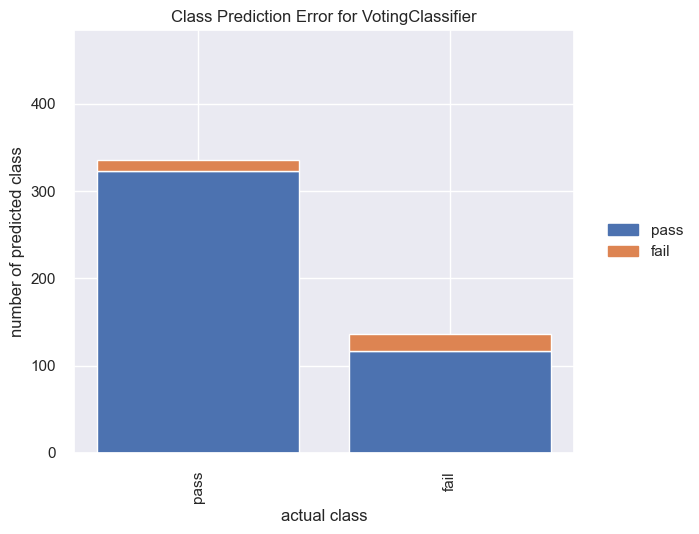

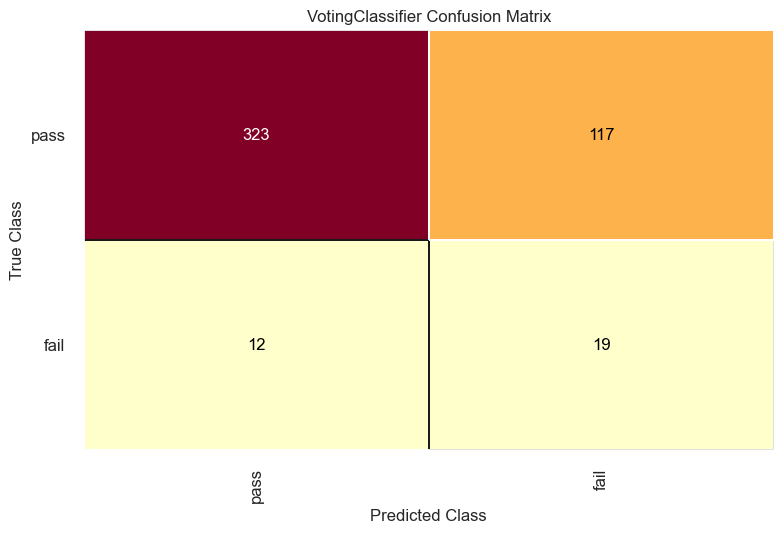

'Run time: 60.44358015060425, F1-score: 0.7261146496815287, MCC: 0.1898617421548941'

In [227]:
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gbm', clf3), ('ada', clf4)], 
                                  voting='soft', weights=[1.5,1,1,1.5], flatten_transform=True)
evaluate2(X_train_rf1, X_test_rf1, y_train_balanced, y_test, ensemble_model)

Let us also have a look at how our `VotingClassifier` measures to the whole dataset

In [269]:
target = df['Pass/Fail']
df_imp = df.drop('Pass/Fail', axis=1)
df_imp = outlier_imputer(df_imp, df_imp, df_imp.columns, 3)
df_imp = nan_imputer(df_imp)


df_rf1 = df_imp[(importance_df_filtered_1['Features'])]

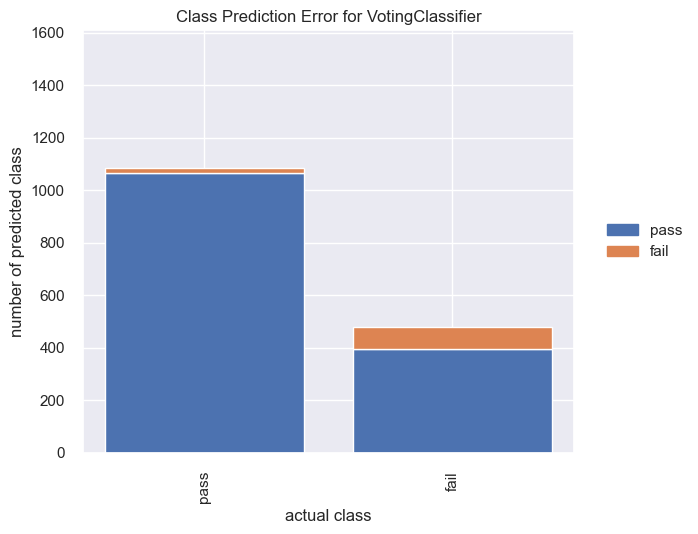

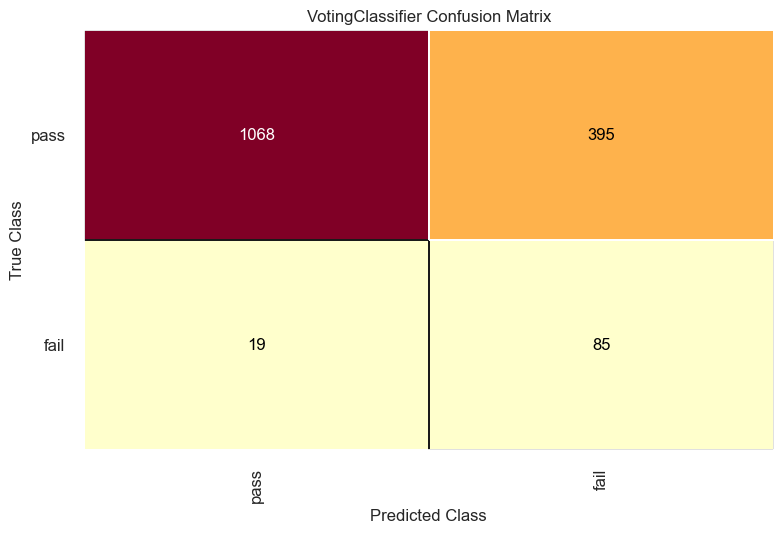

'Run time: 61.15015959739685, F1-score: 0.7358008934269304, MCC: 0.29555643395156905'

In [271]:
evaluate2(X_train_rf1, df_rf1, y_train_balanced, target, ensemble_model)

This is our final model, let us save it as a `.pkl` file in our environment

In [272]:
model = ensemble_model
model.fit(X_train_rf1, y_train_balanced)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight={0: 1, 1: 2})),
                             ('rf',
                              RandomForestClassifier(class_weight={0: 1, 1: 15},
                                                     max_depth=16,
                                                     min_samples_leaf=10,
                                                     n_estimators=20,
                                                     random_state=12)),
                             ('gbm',
                              GradientBoostingClassifier(learning_rate=0.004,
                                                         max_depth=1,
                                                         min_samples_leaf=10,
                                                         n_estimators=500,
                                                         random_state=12)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.003,
                                                 n_estimators=1000,
                                                 random_state=12))],
                 voting='soft', weights=[1.5, 1, 1, 1.5])

In [273]:
model_pkl_file = "uci_semiconductor_model.pkl"  

In [274]:
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)